# Function that generates points for:
# 1）Sphere
# 2）Elpisoid


In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Generate points on surface of sphere
def sphere(radius, num_points, uniform=True, plot=False):
    structure = set()
    
    phi = np.linspace(0, np.pi, num_points)
    theta = np.linspace(0, 2 * np.pi, num_points)
    theta, phi = np.meshgrid(theta, phi)

    if not uniform:
        radius = np.random.rand(num_points, num_points) * radius

    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)

    for i in range(len(x)):
        for j in range(len(x[i])):
           # a = (round(x[i][j]),round(y[i][j]),round(z[i][j])) # Will round to nearest ones
            a = (x[i][j],y[i][j],z[i][j]) # group values of x, y, z
            structure.add(a)

    if plot:
        # Plot Structure
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(projection='3d')
        
        ax.scatter(x,y,z)
        plt.show()
        
    return structure

In [ ]:
# Generate points on surface of sphere
def elipsoid_uniform(radius, num_points, plot=False):
    structure = set()
    
    phi = np.linspace(0, np.pi, num_points)
    theta = np.linspace(0, 2 * np.pi, num_points)
    theta, phi = np.meshgrid(theta, phi)
    
    x = radius * np.sin(phi) * np.cos(theta)
    y = 5*radius * np.sin(phi) * np.sin(theta)
    z = 0.5 *radius * np.cos(phi)

    for i in range(len(x)):
        for j in range(len(x[i])):
           # a = (round(x[i][j]),round(y[i][j]),round(z[i][j])) # Will round to nearest ones
            a = (x[i][j],y[i][j],z[i][j]) # group values of x, y, z
            structure.add(a)

    if plot:
        # Plot Structure
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(projection='3d')
        
        ax.scatter(x,y,z)
        plt.show()
        
    return structure

In [7]:
def points_projection(structure_coords, num_points):
    
    # normal points generation
    normal = sphere(1, num_points)

	# Projection 
	# Assign structure coords into z
    structure_coords = list(structure_coords)
    z = np.array(structure_coords)   
    
    all_projected_points = []
    
    for n in normal:
        #Find two orthogonal vectors u and v (both orthogonal to n)
        #Calc value for t (random vector), ensuring not a scaled version of n
        if n[0] != 0:
            t = np.array([-(n[1]+n[2]) / n[0], 1, 1])
        elif n[1] != 0:
            t = np.array([-(n[0]+n[2]) / n[1], 1, 1])
        else:
            t = np.array([-(n[0]+n[1]) / n[2], 1, 1])
        
        u = np.cross(t,n)
        v = np.cross(n,u)
        
        # Normalize u and v (vector length become 1 unit long)
        u = u / np.linalg.norm(u)
        v = v / np.linalg.norm(v)
        
        vec_mat = np.array([u,v])
        
        #Project structure points onto plane
        #Individual component of normal
        a = n[0]
        b = n[1]
        c = n[2]
        #d = 0 #component of equation of planes

        projected_points = []
        
        for point in z:
            z1, z2, z3 = point
            
            k = (0 - a*z1 - b*z2 - c*z3) / (a**2 + b**2 + c**2) 
            
            p1 = z1 + k*a
            p2 = z2 + k*b
            p3 = z3 + k*c
            
            p = np.array([p1,p2,p3])

            #Convert 3D points to 2D
            p_trans = p.transpose()
            proj_2d = np.dot(vec_mat,p_trans)
            projected_points.append(proj_2d)
            
        all_projected_points.append(projected_points)

    return np.array(all_projected_points)

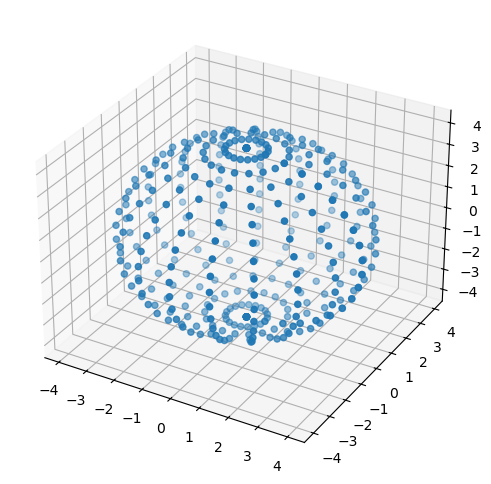

In [13]:
structure = sphere(4, 20, True, True)

In [80]:
projections = points_projection(structure, 10)

In [68]:
print(projections[0])

[[-3.25789368  2.31993559]
 [-0.54733289 -0.31600279]
 [-1.20300396 -0.33259497]
 ...
 [ 1.49811361  0.57234634]
 [-1.90619867  2.96610302]
 [ 3.41147413  0.60153493]]


In [82]:
#Place projected points into grid and count points per grid cell 
def cluster_per_cell(projected_points, image_size, grid_size):
    
    all_projections = np.array(projected_points)
    image_size = image_size
    grid_x = grid_size[0]
    grid_y = grid_size[1]
    
    #Calc size of grid cell
    cell_x = image_size[0] / grid_x
    cell_y = image_size[1] / grid_y

    for projection in all_projections:
        grid = np.zeros((grid_x,grid_y), dtype=int)
        
        #Normalise 2D coords for better scalling (between 0-1)
        min_val = np.min(projection, axis=0)
        max_val = np.max(projection, axis=0)
        
        #Feature scaling 
        points_norm = (projection - min_val) / (max_val - min_val) 
        
        scaled_points = (points_norm * (np.array(image_size) - 1)).astype(int)
        
        for points in scaled_points:
            x,y = points
            gridx_index = int(x // cell_x) #floor division followed by conversion to integer
            gridy_index = int(y // cell_y)
            grid[gridy_index, gridx_index] += 1
    
        # Plot the image and grid
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Draw the grid
        for row in range(grid_y + 1):
            ax.axhline(row * cell_y, color='black', linewidth=0.5)
        for col in range(grid_x + 1):
            ax.axvline(col * cell_x, color='black', linewidth=0.5)
        
        plt.gca().invert_yaxis()
    
        #Plot the points 
        ax.scatter(scaled_points[:,0], scaled_points[:,1], c="red", marker="." )
        
        #Plot numbers on grid
        for i in range(len(grid)):
            for j in range(len(grid)):
                ax.text( j * cell_y +(cell_y / 2), i * cell_x + (cell_x / 2), 
                        grid[i,j], fontsize = 20, color='blue', ha='center', va='center')
                
        
        #set axis labels
        ax.set_xlim(0 , image_size[1])
        ax.set_ylim(image_size[0], 0)
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title(f'Points Distribution with Grid Size: {image_size}')
        
       
        plt.show()

    return  grid

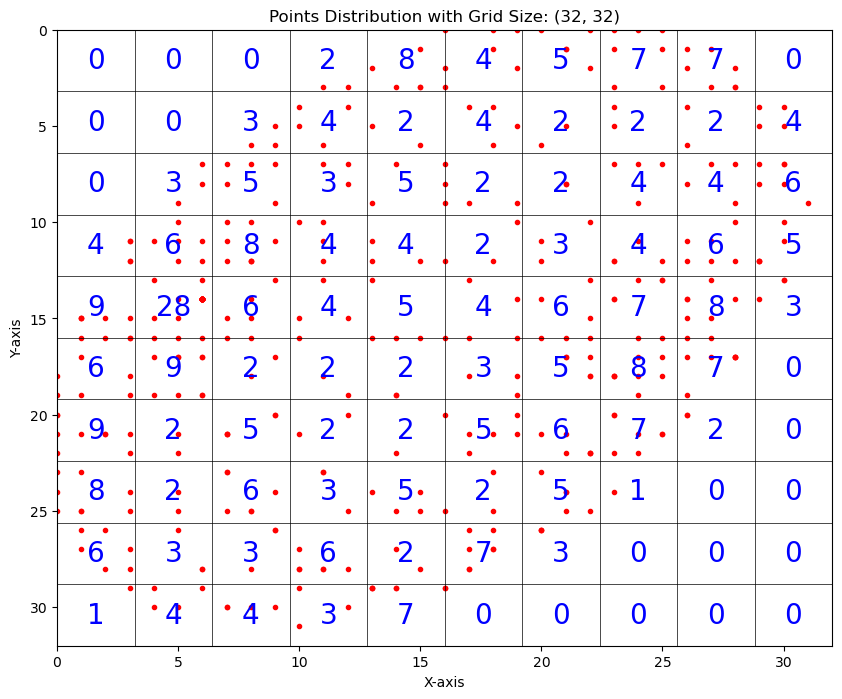

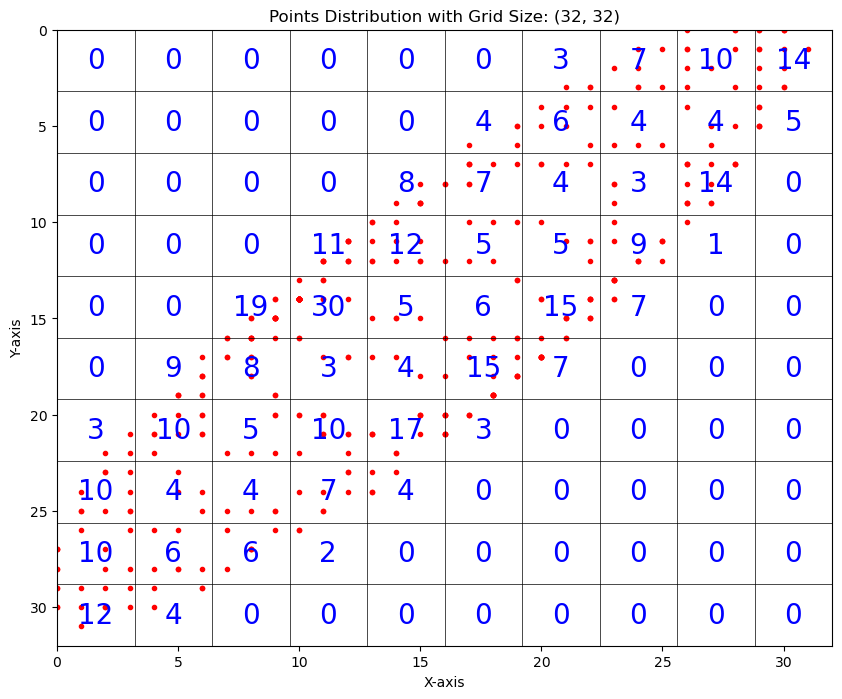

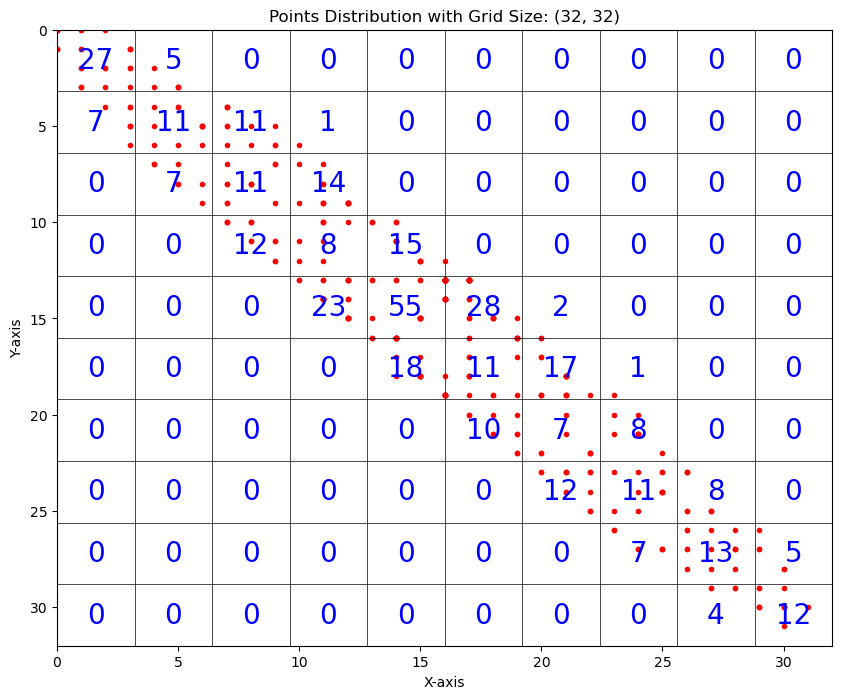

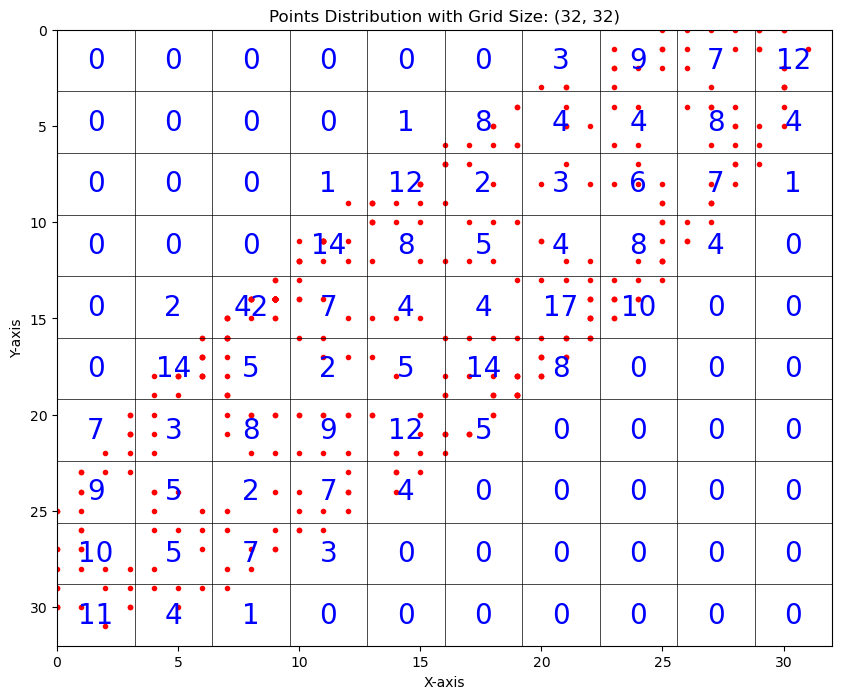

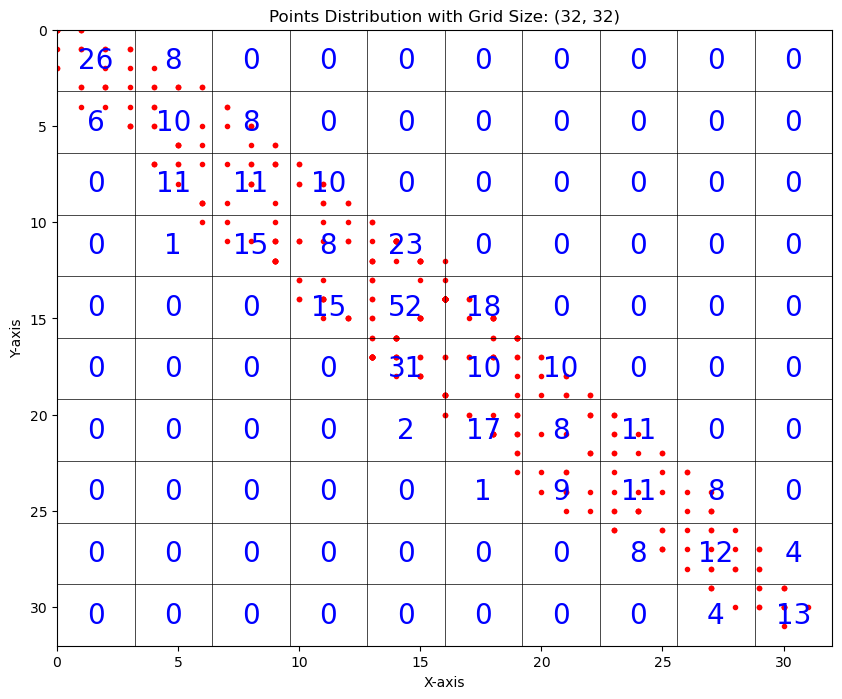

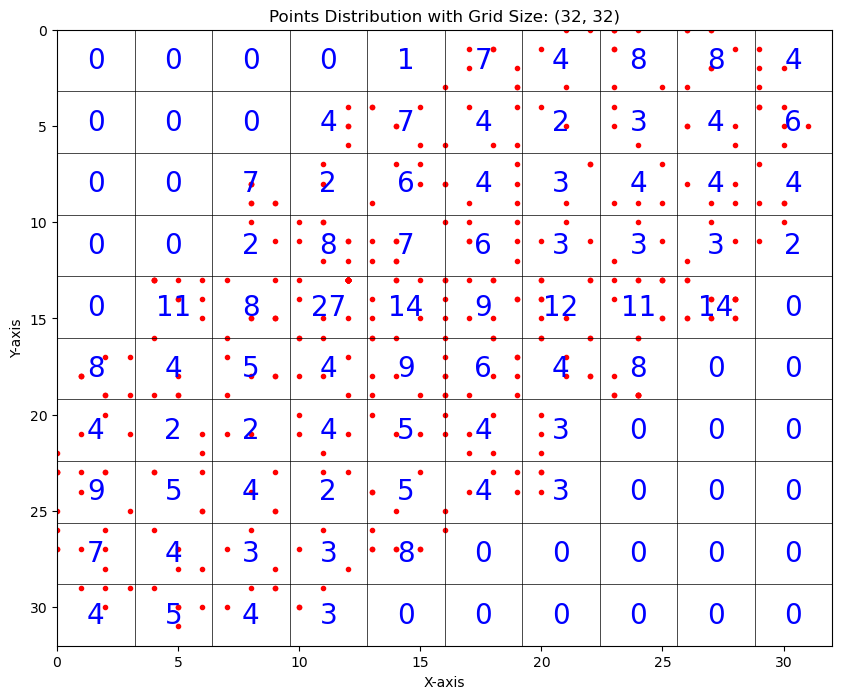

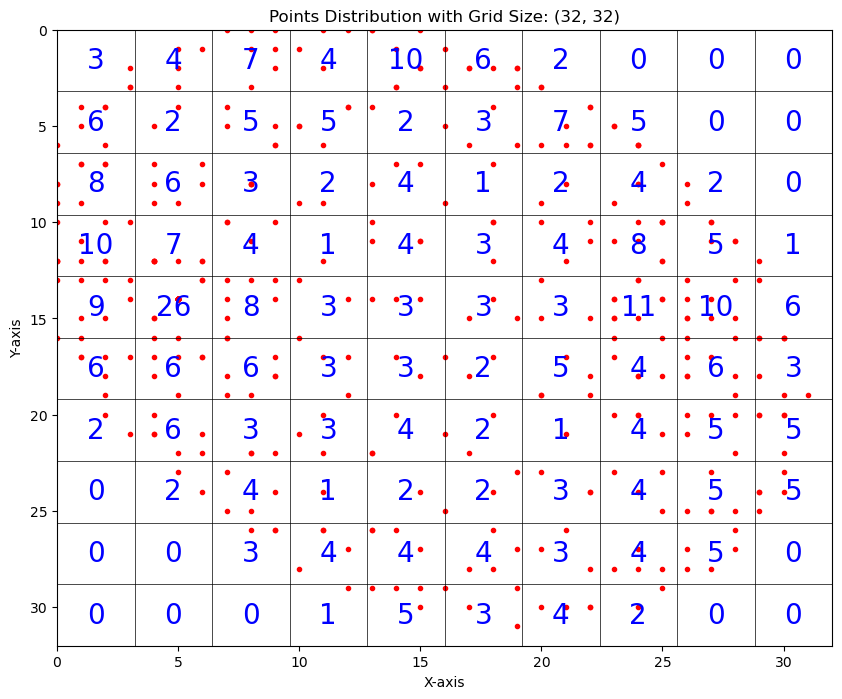

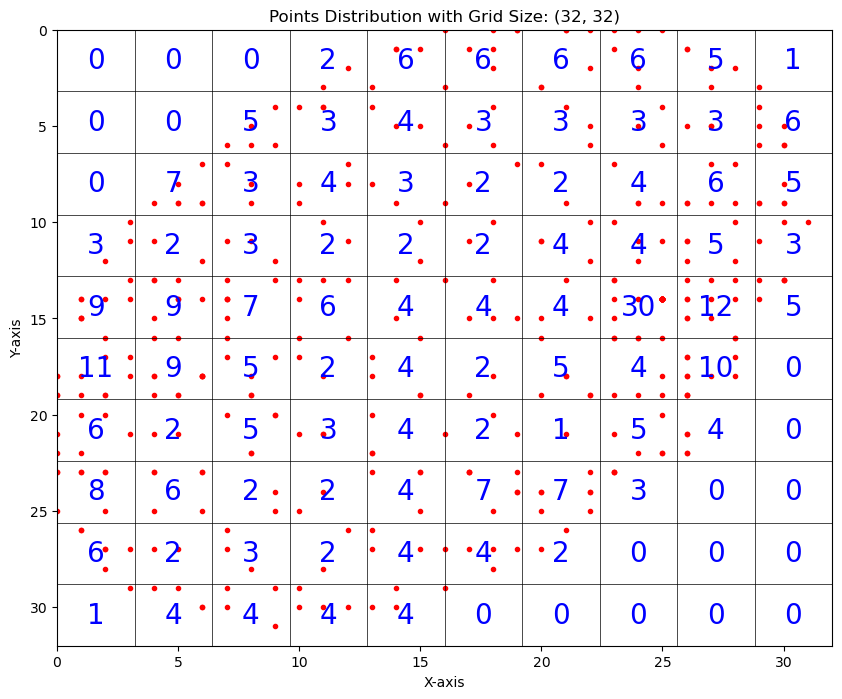

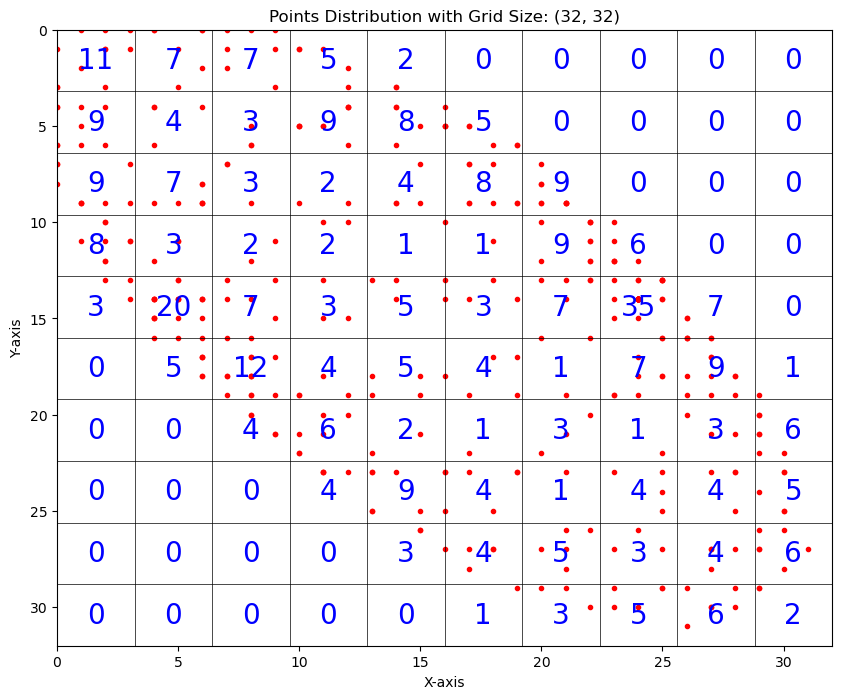

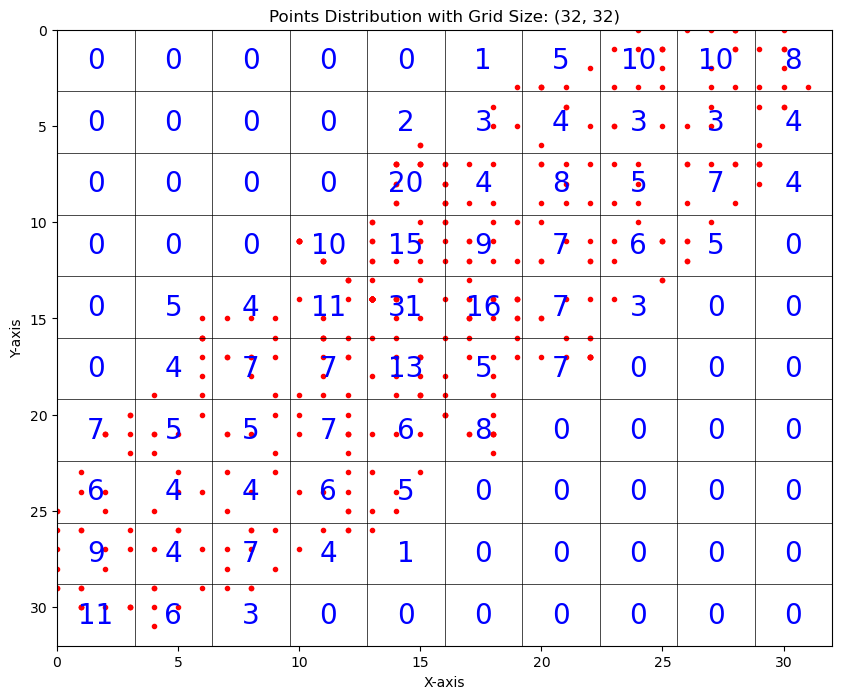

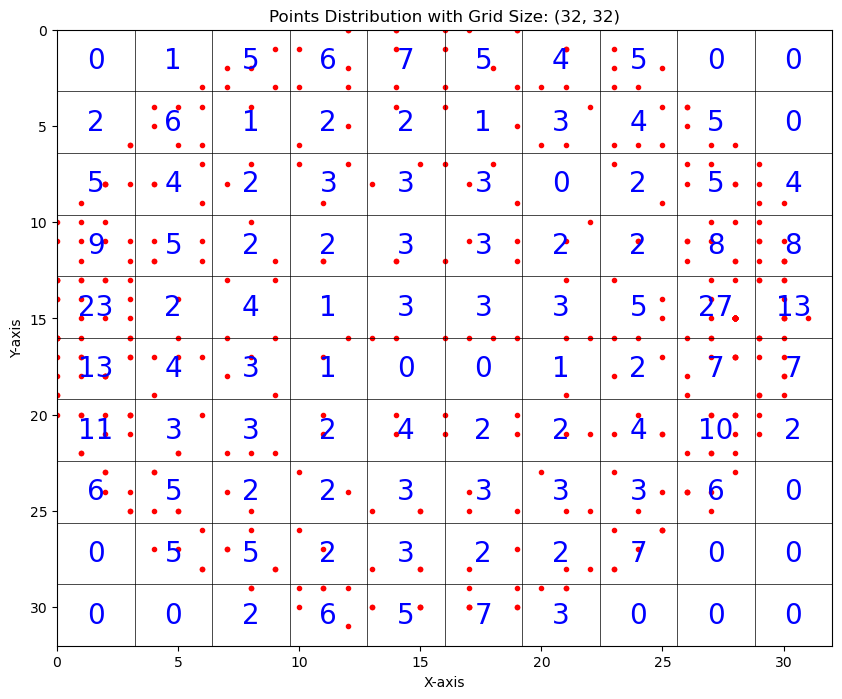

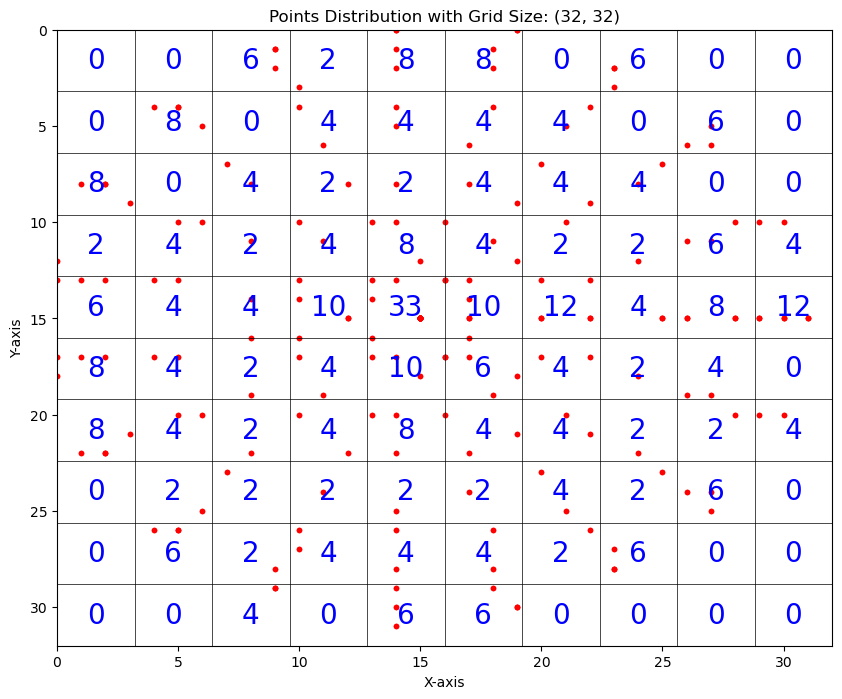

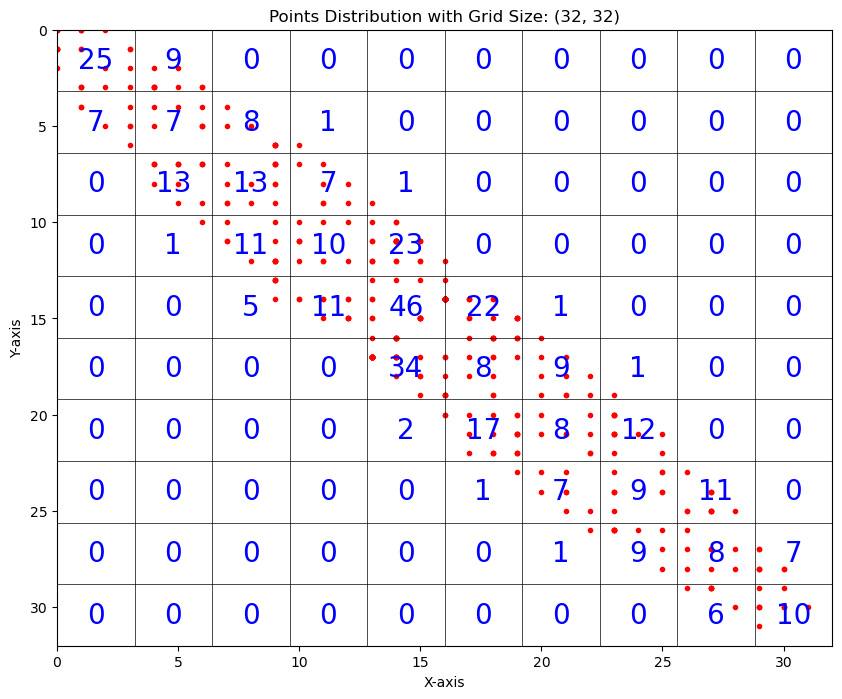

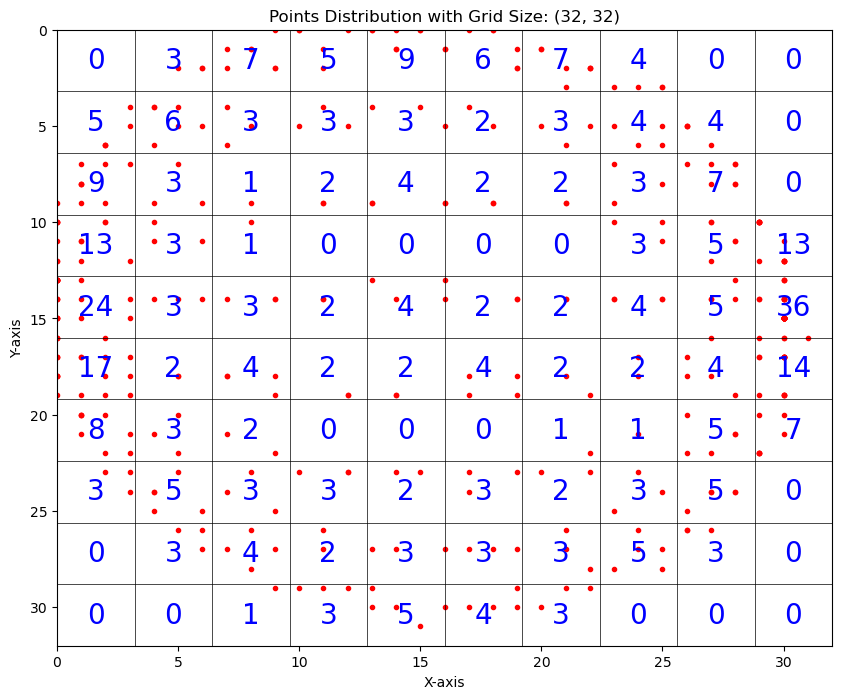

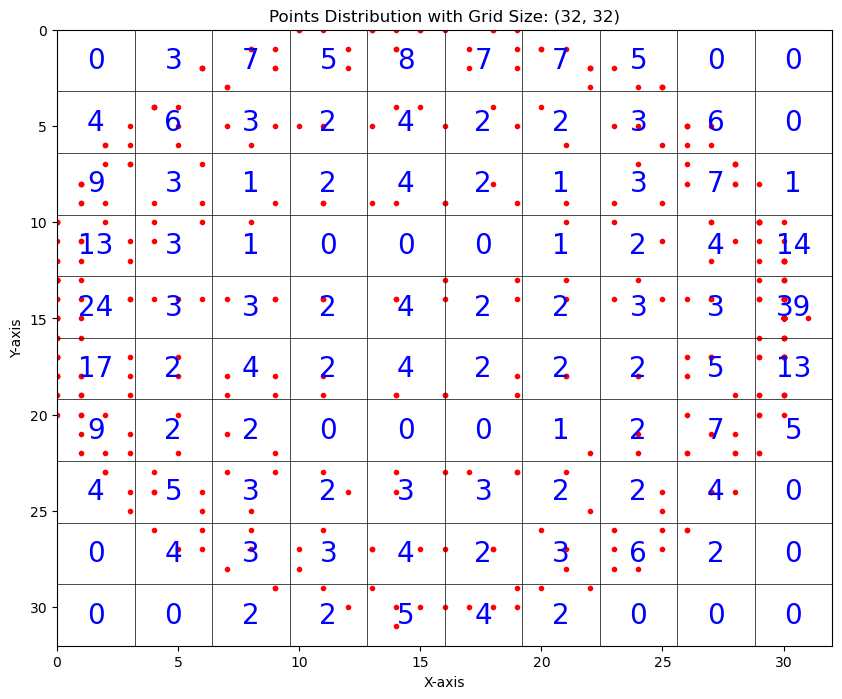

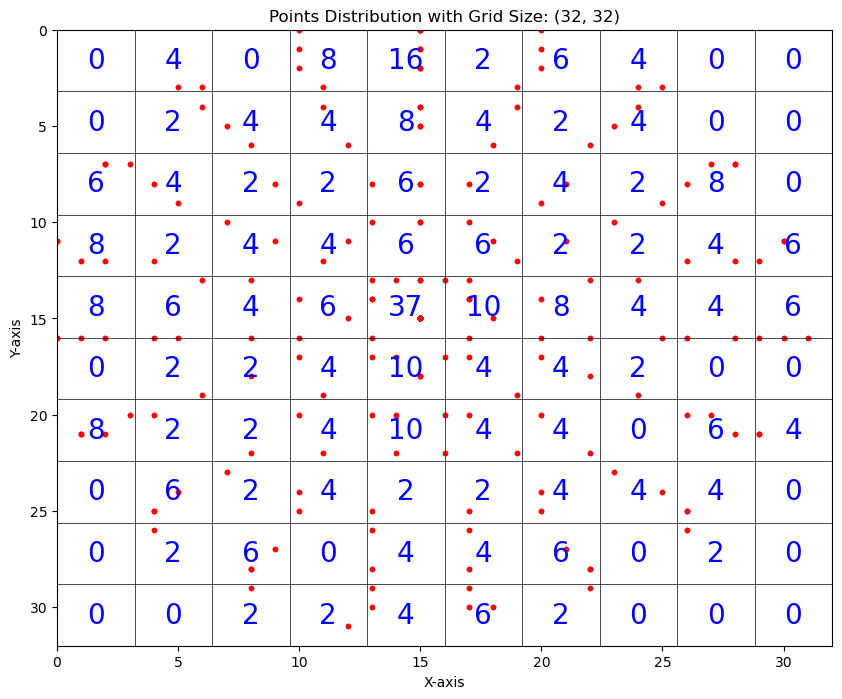

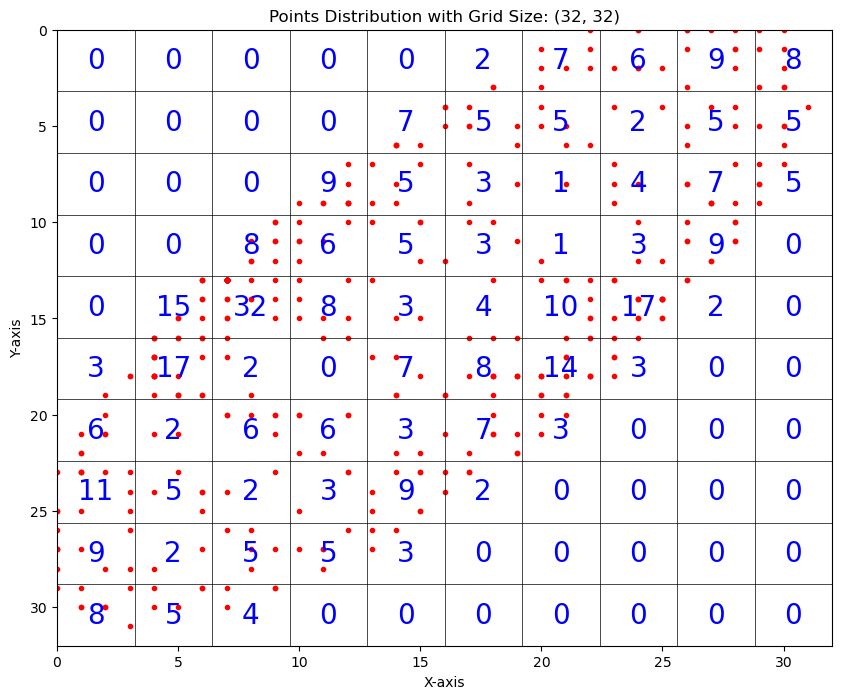

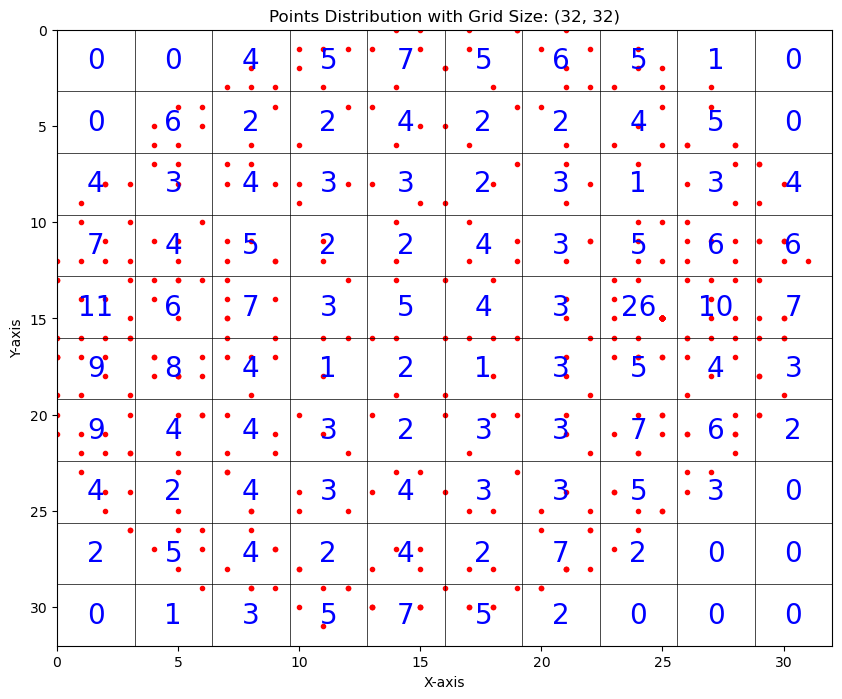

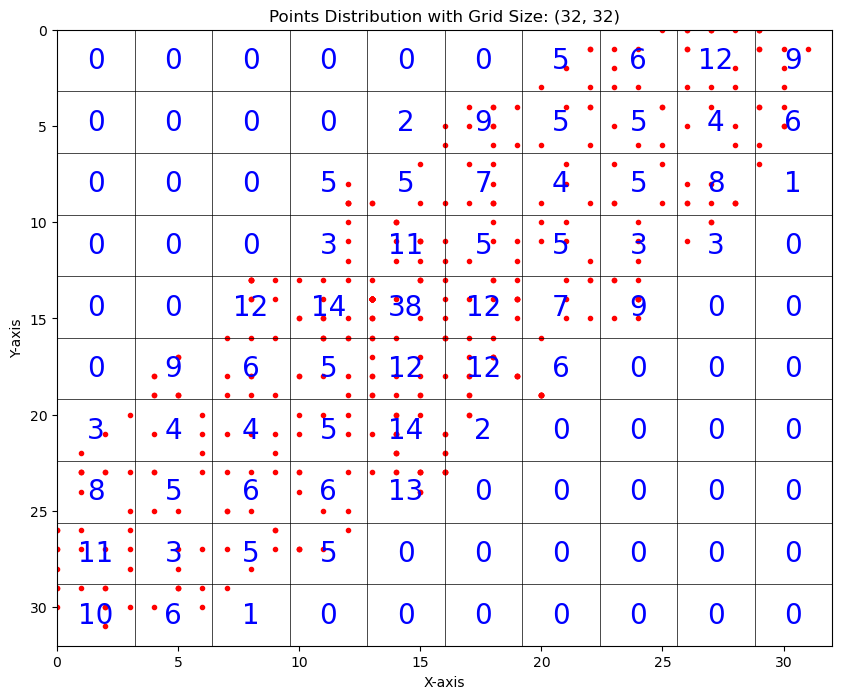

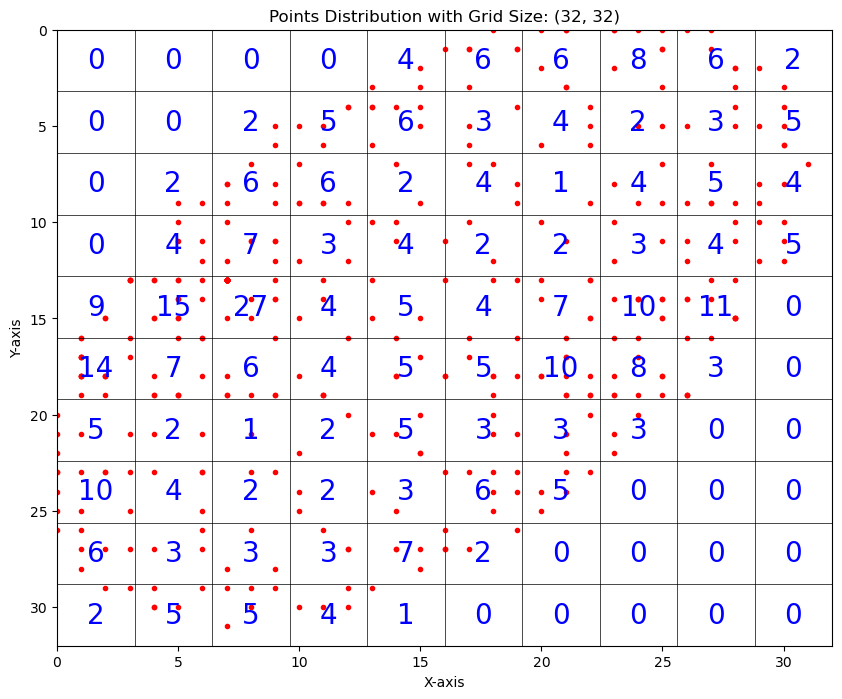

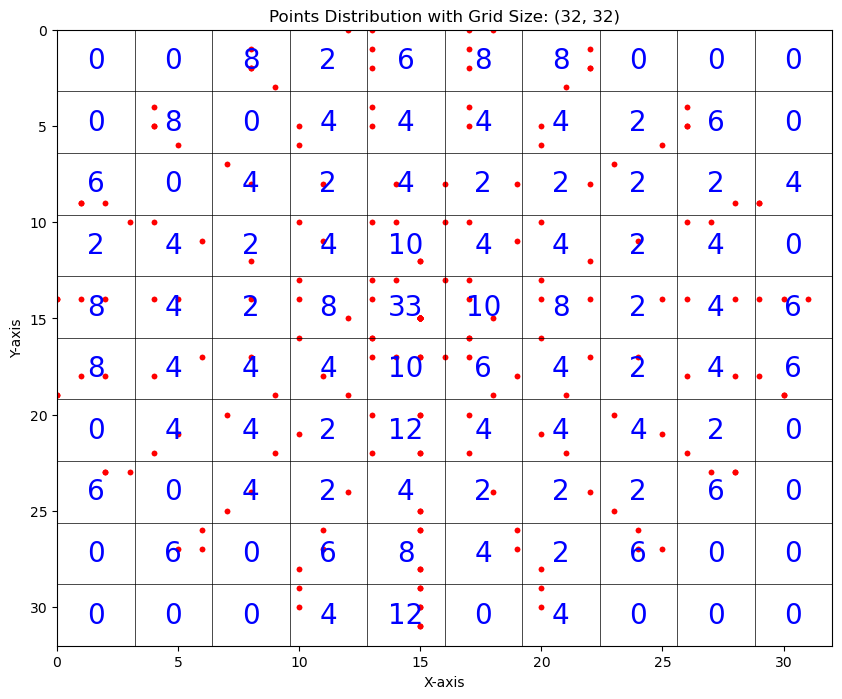

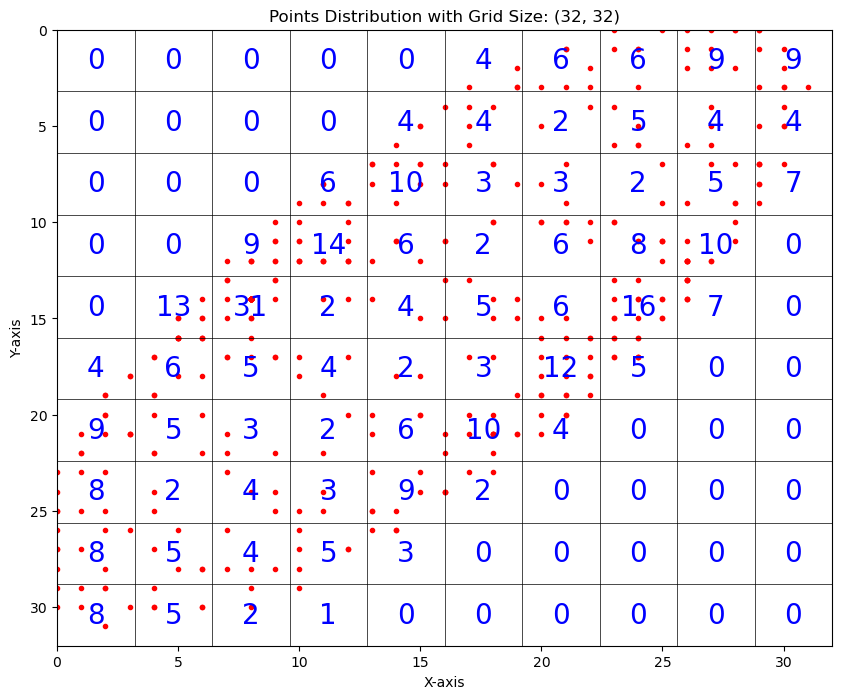

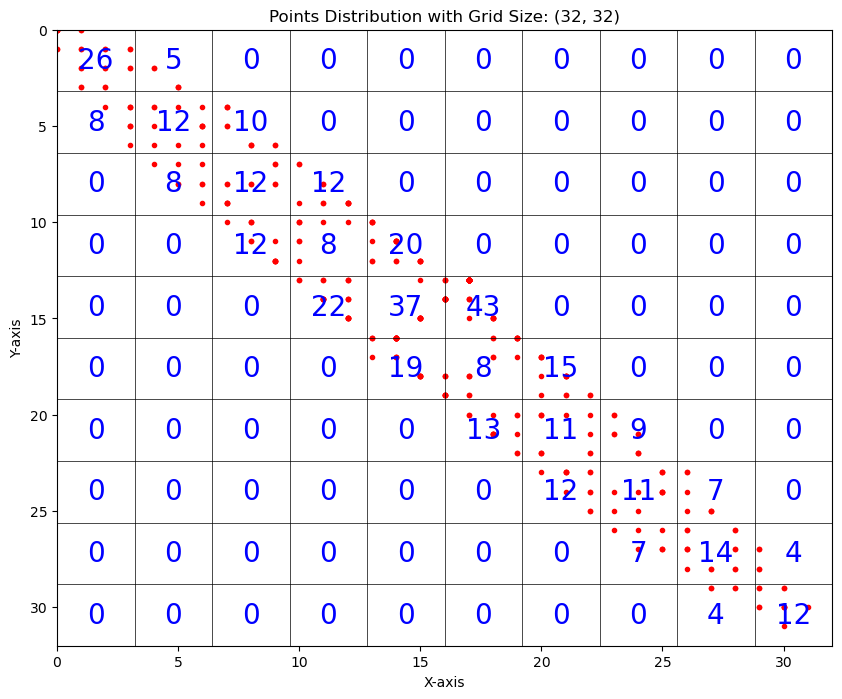

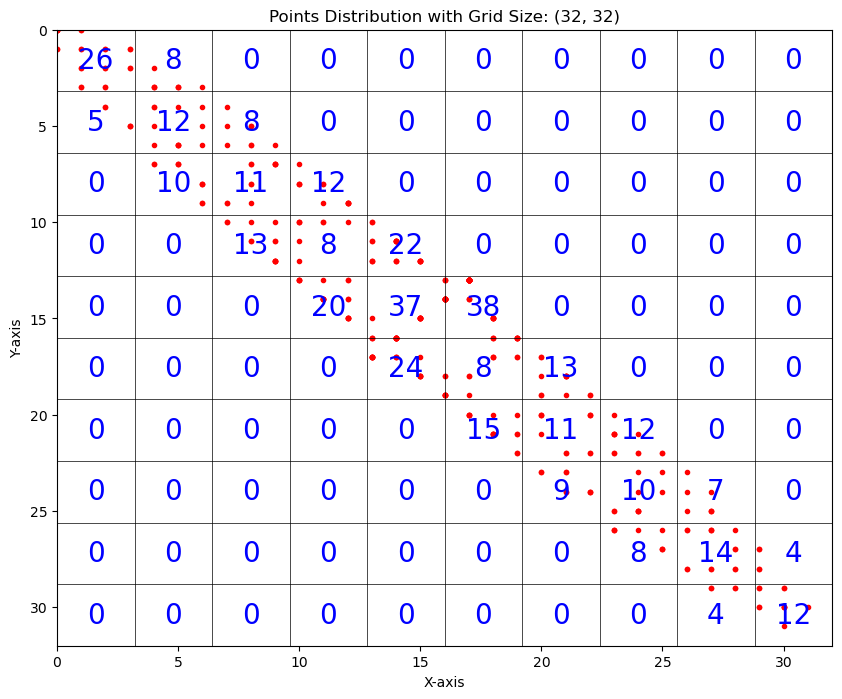

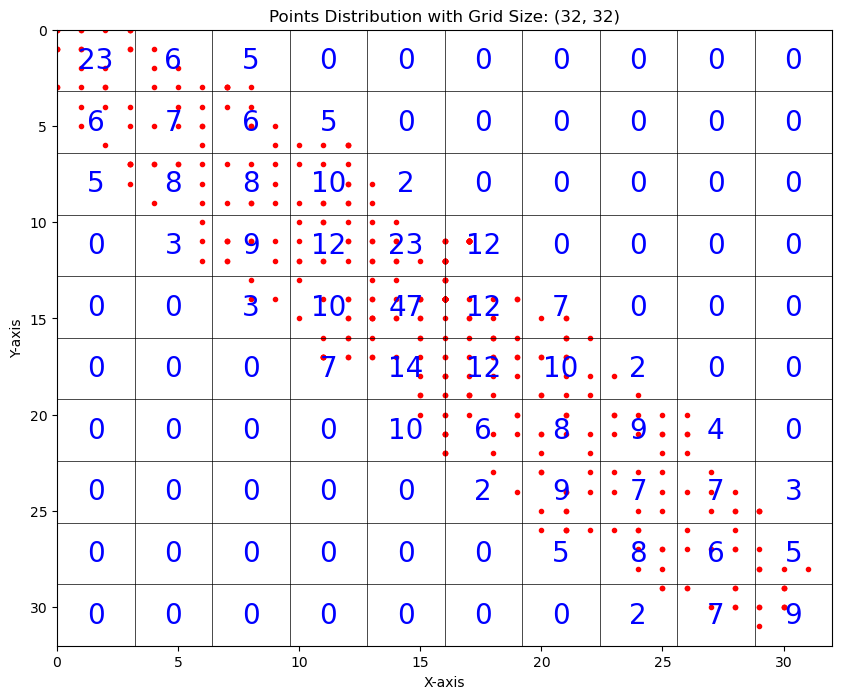

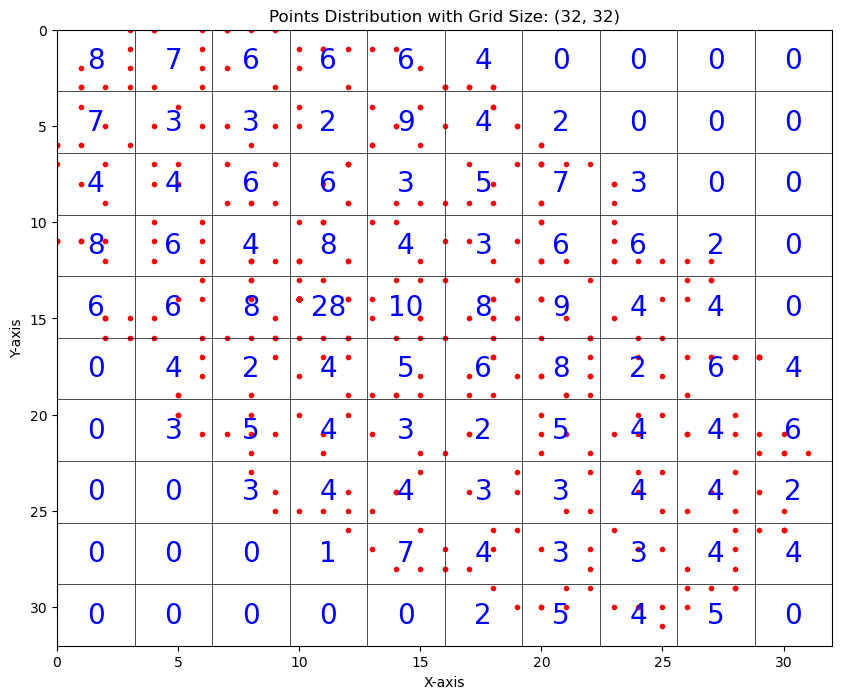

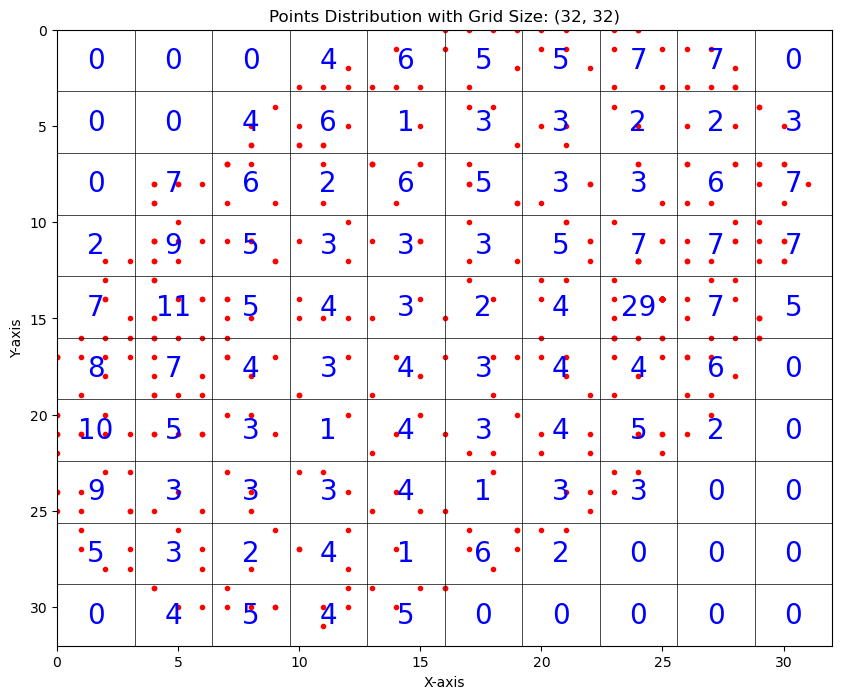

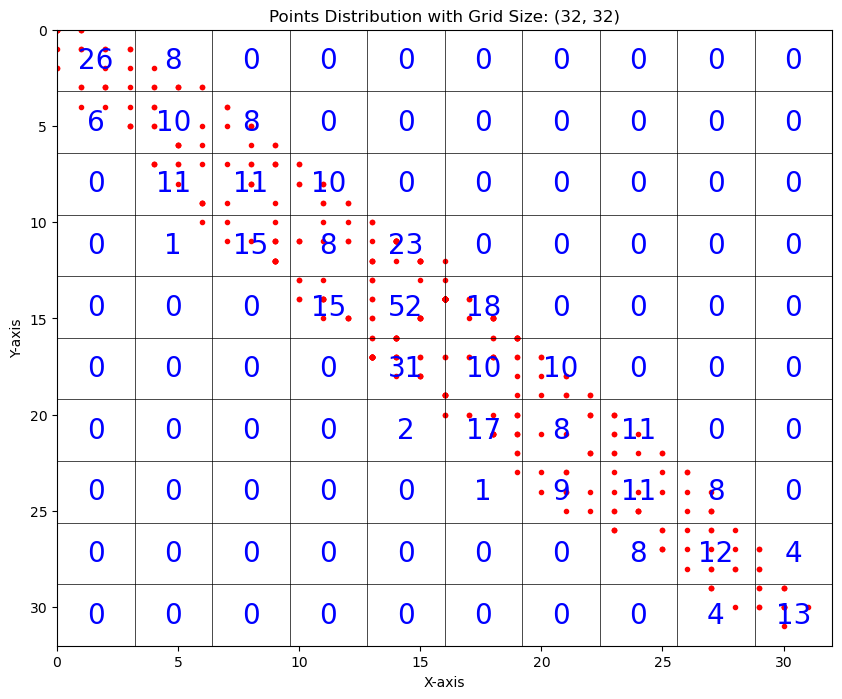

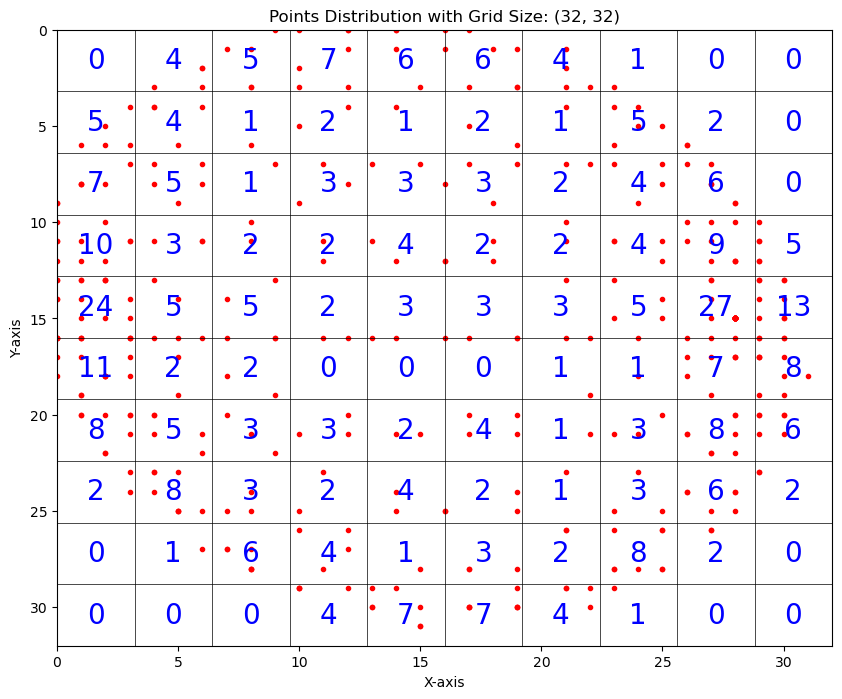

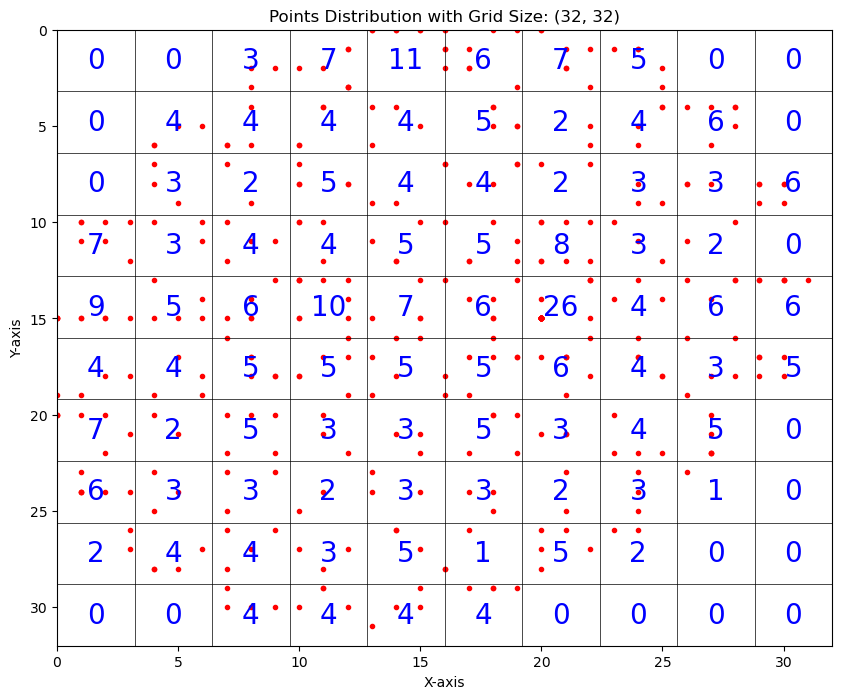

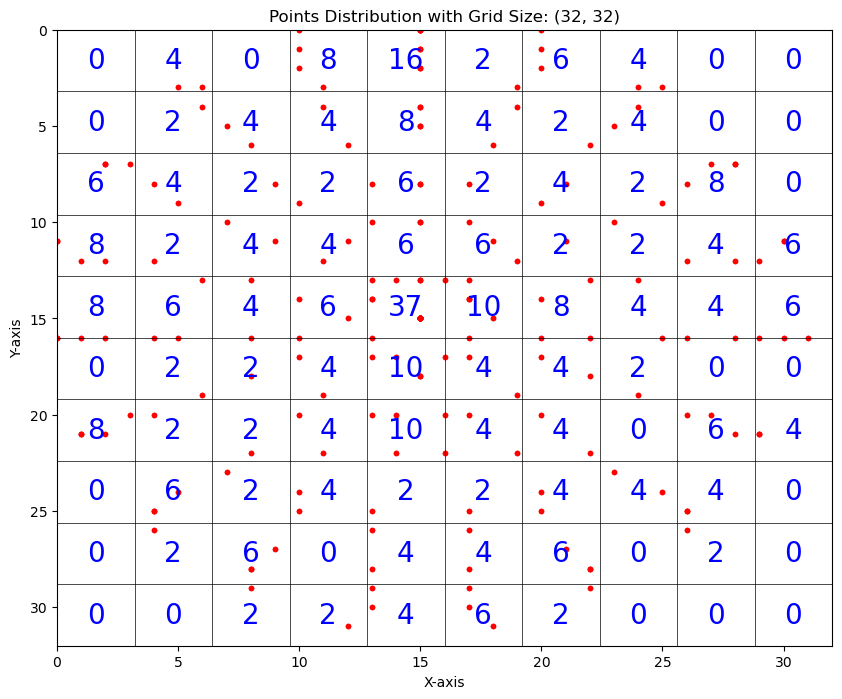

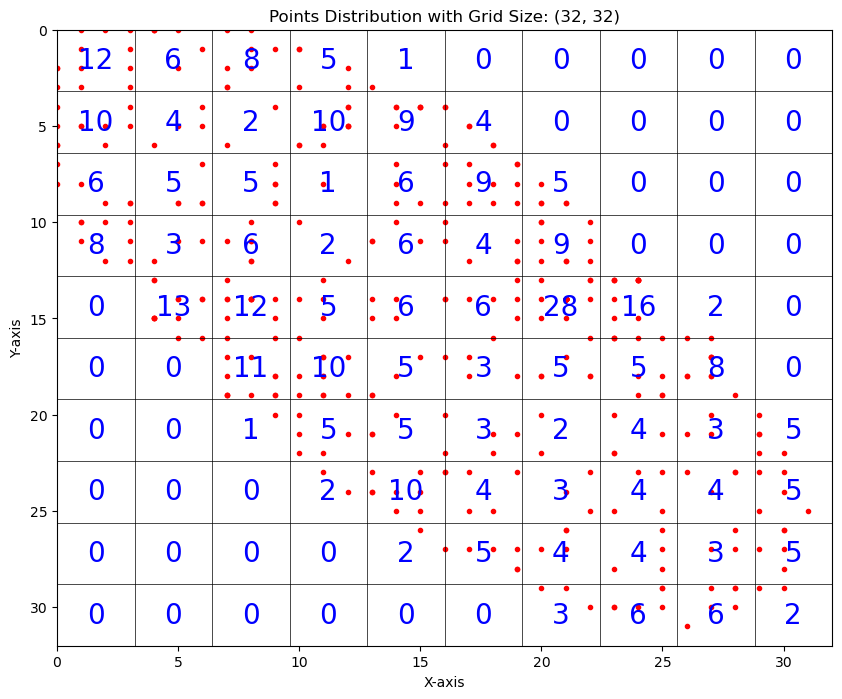

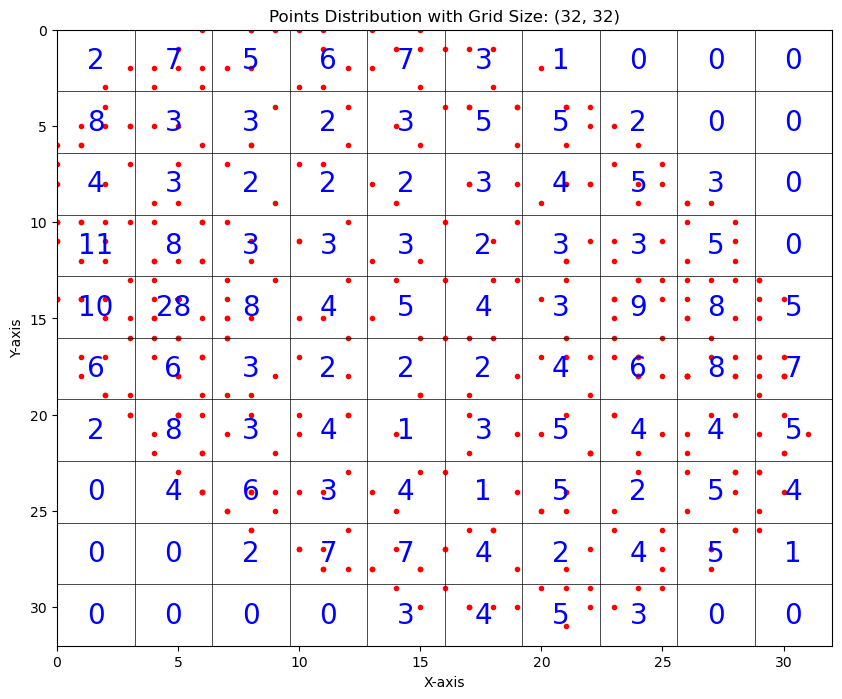

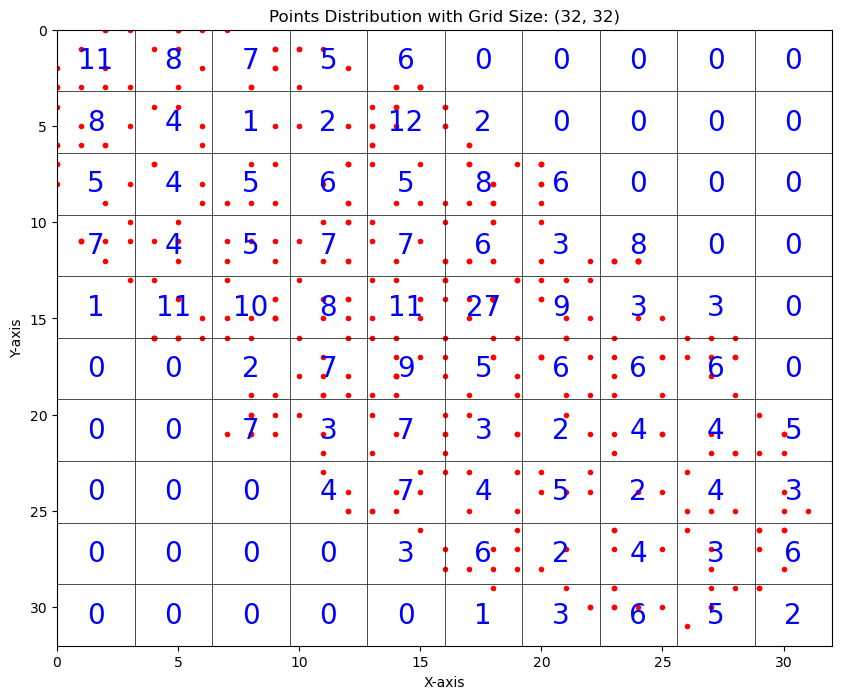

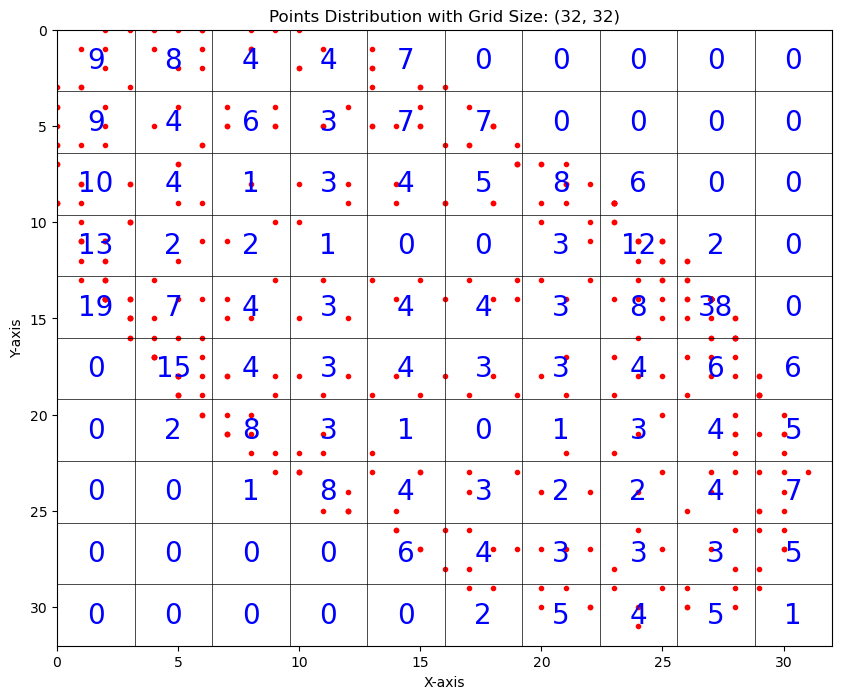

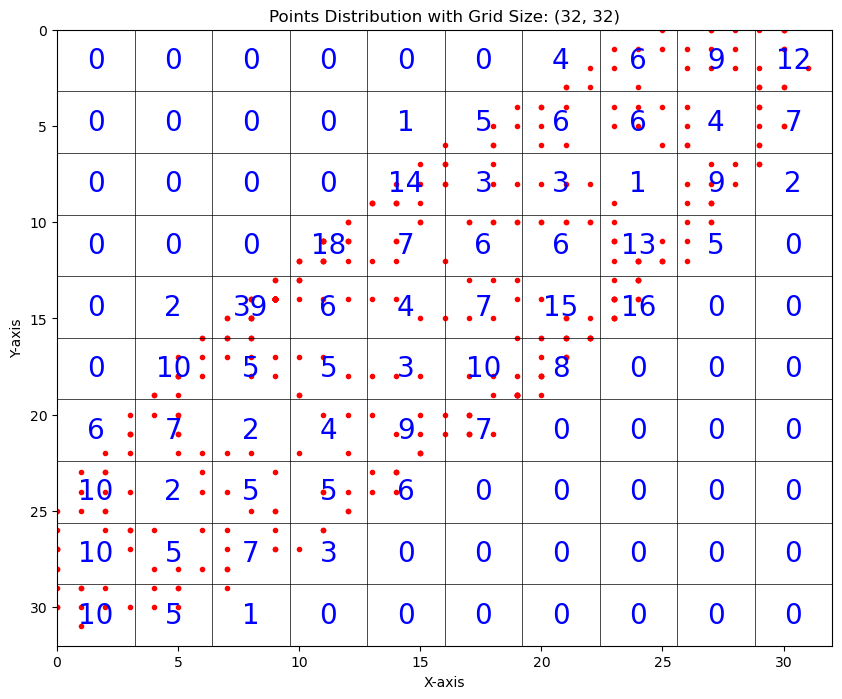

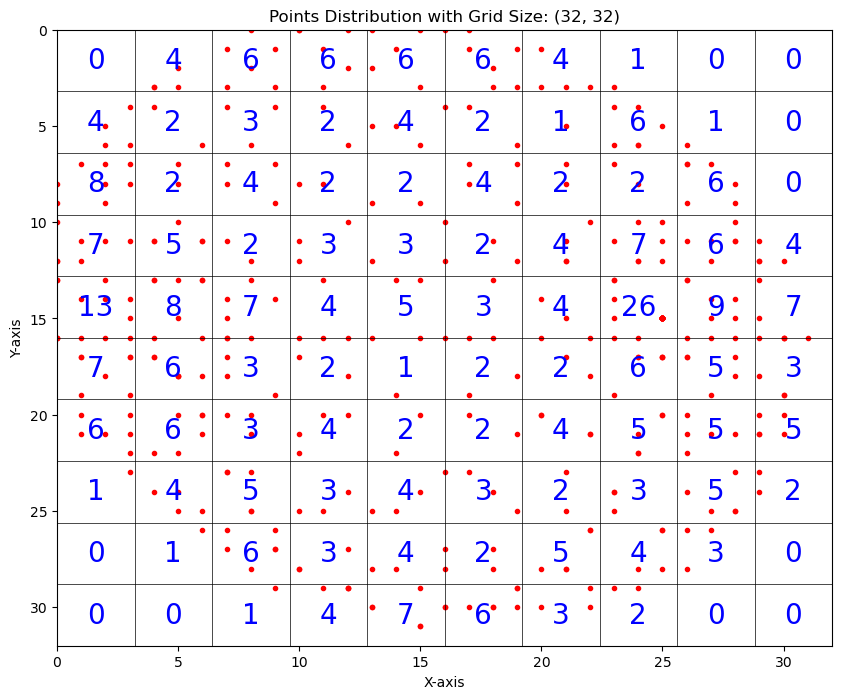

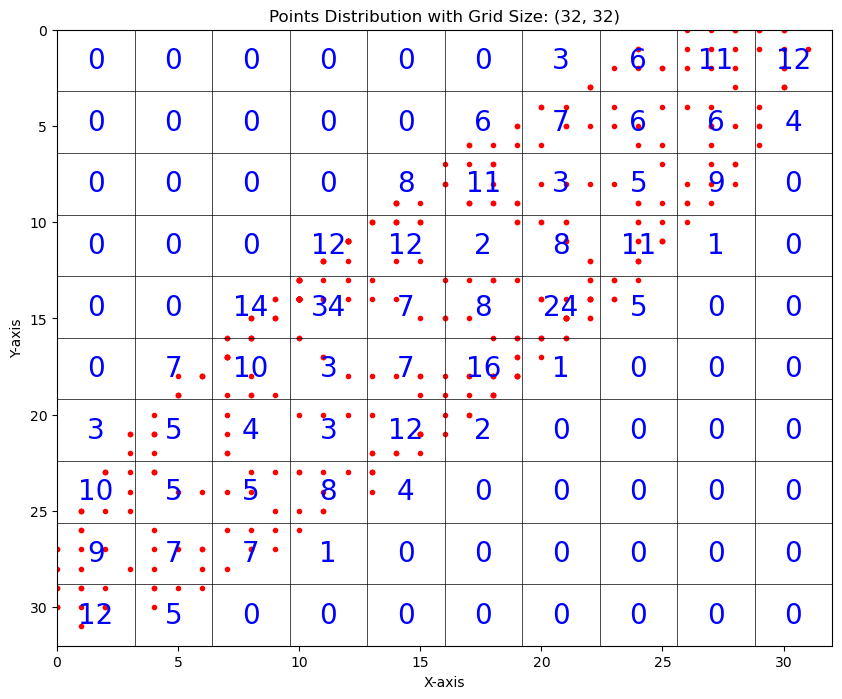

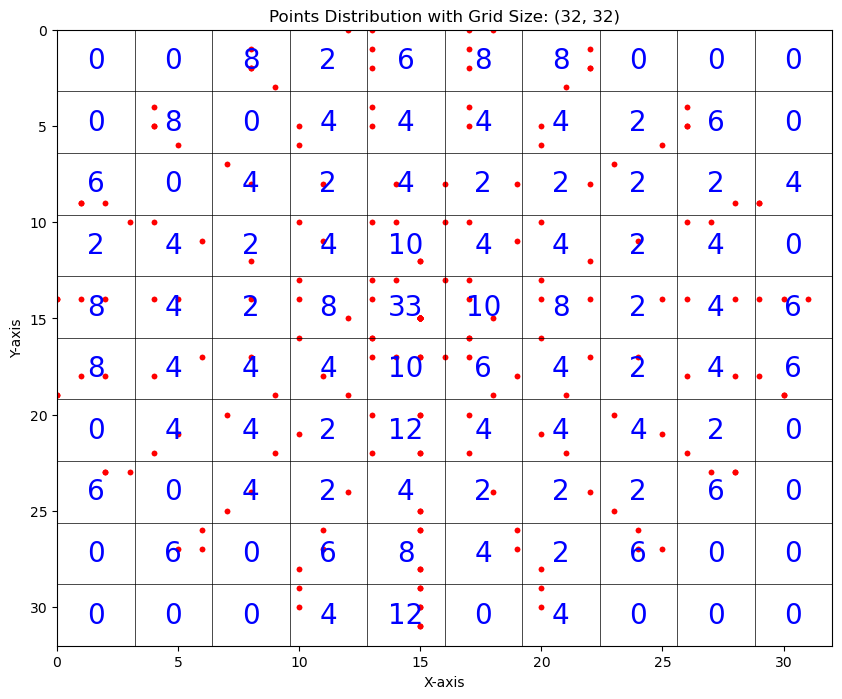

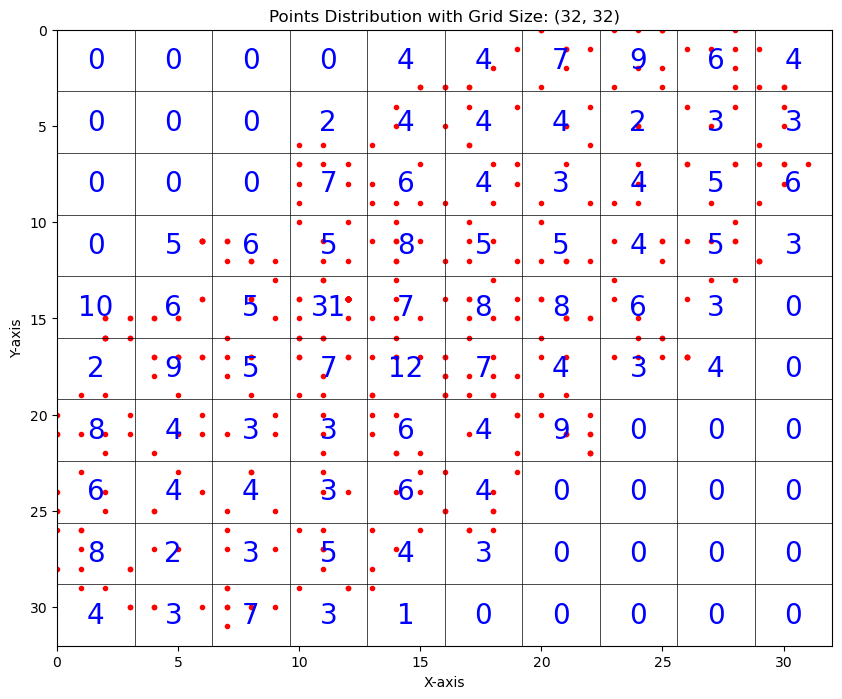

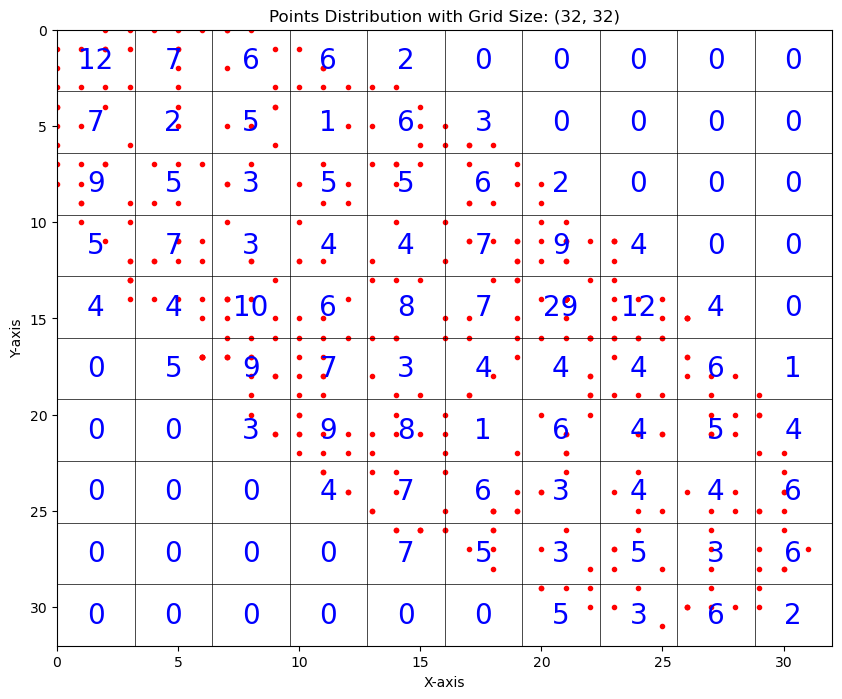

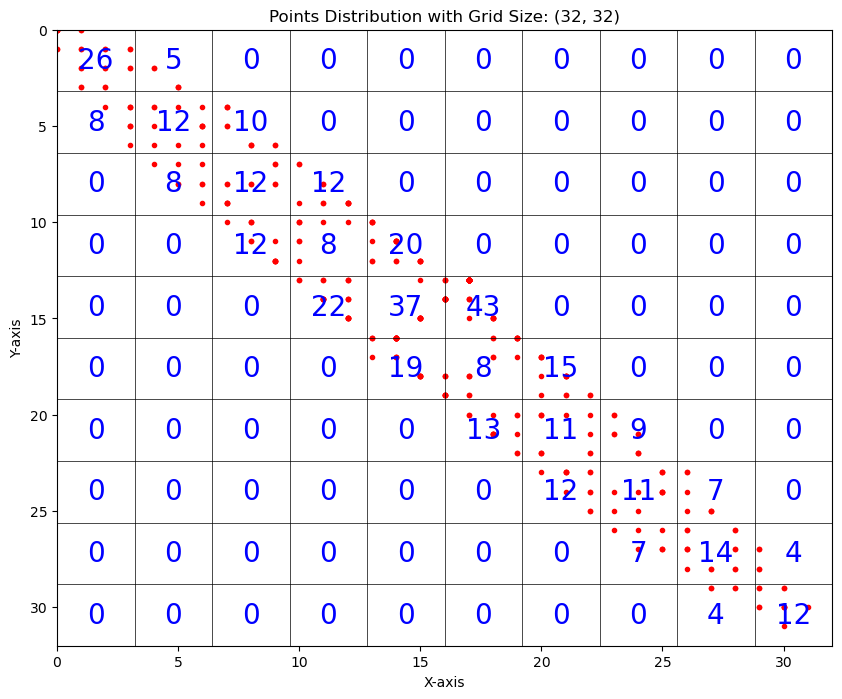

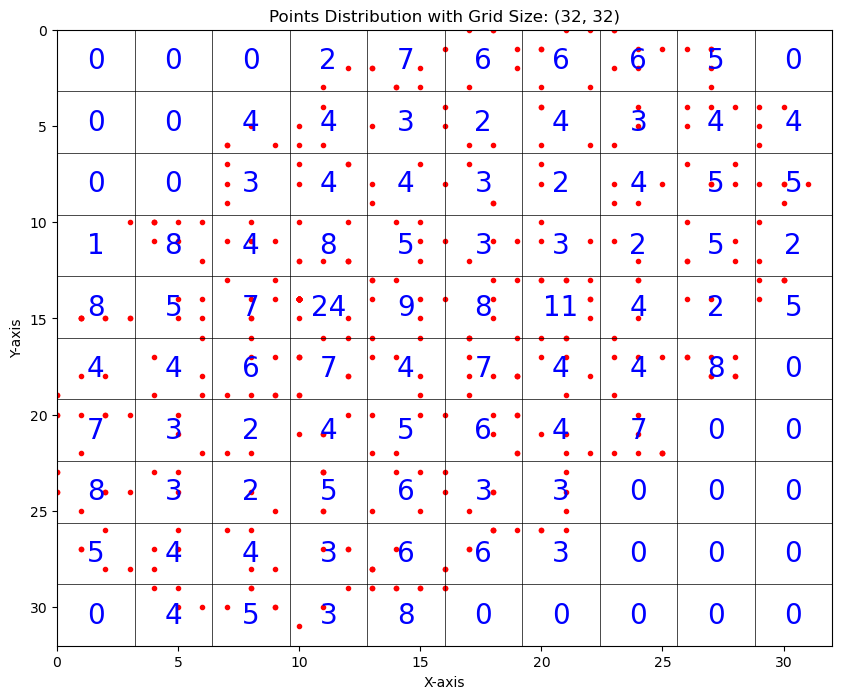

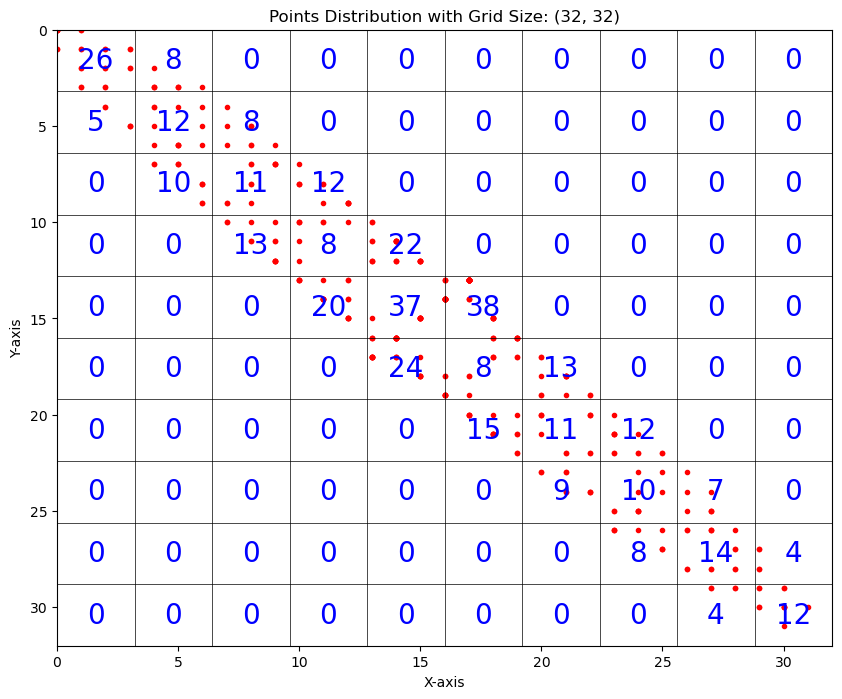

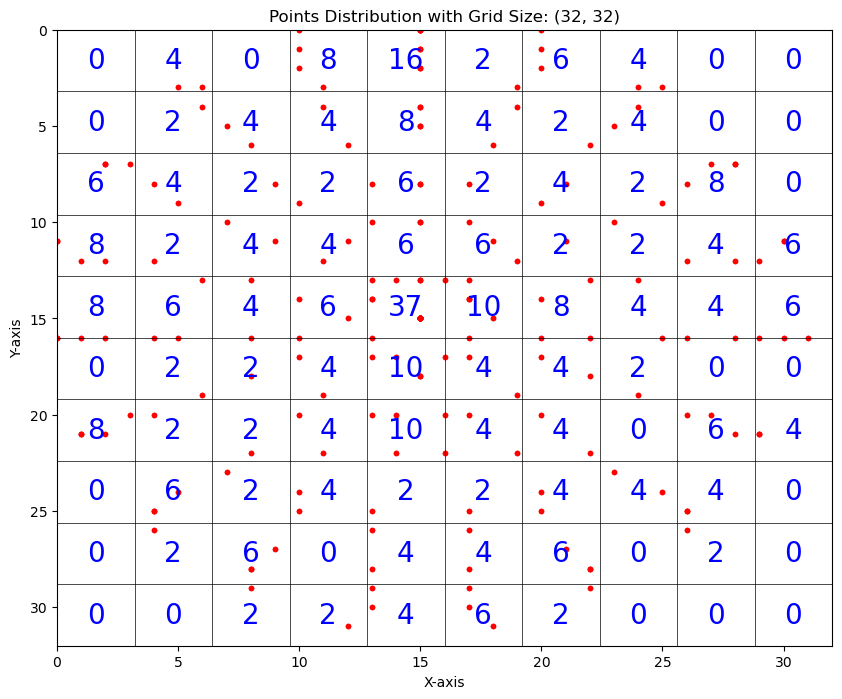

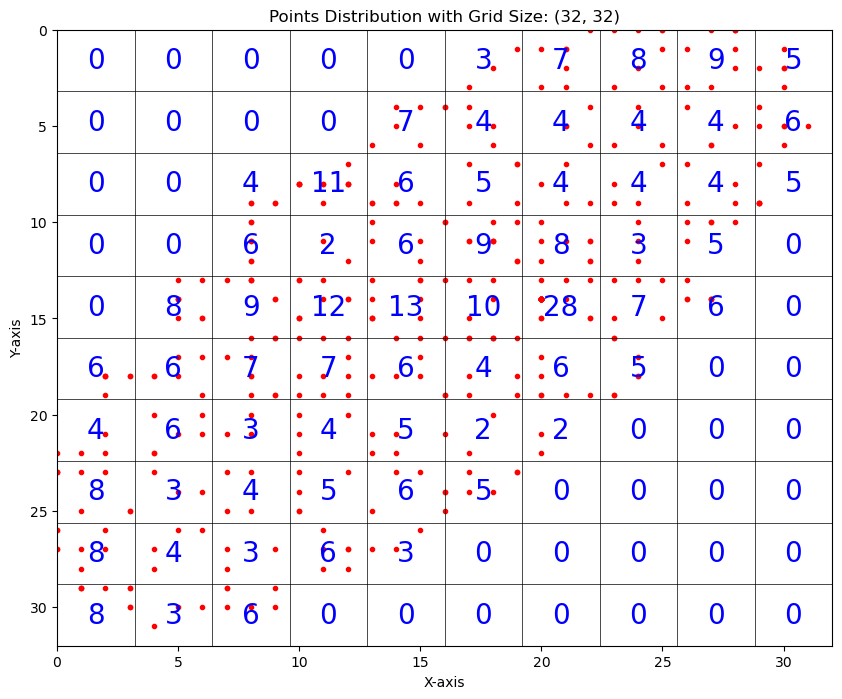

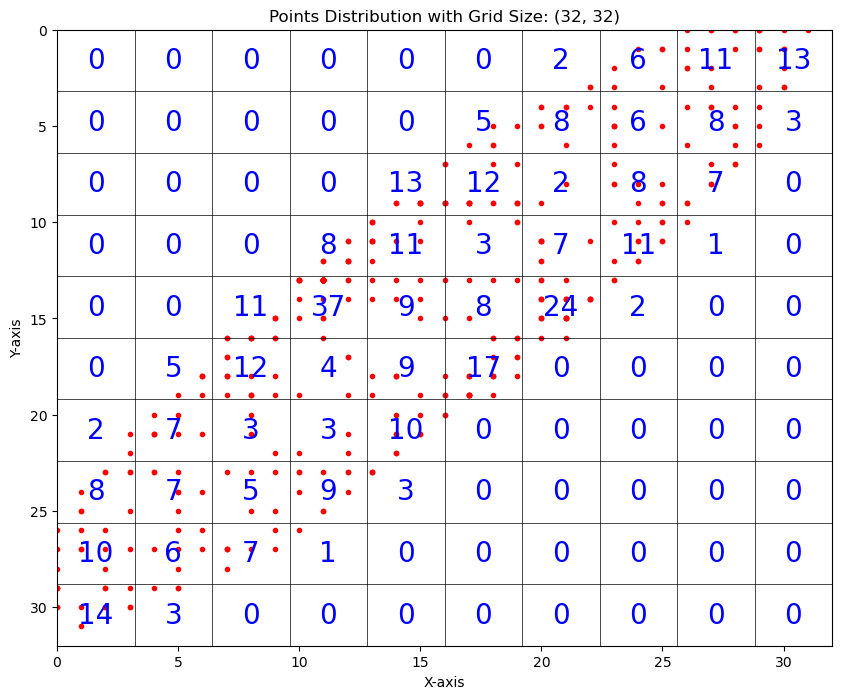

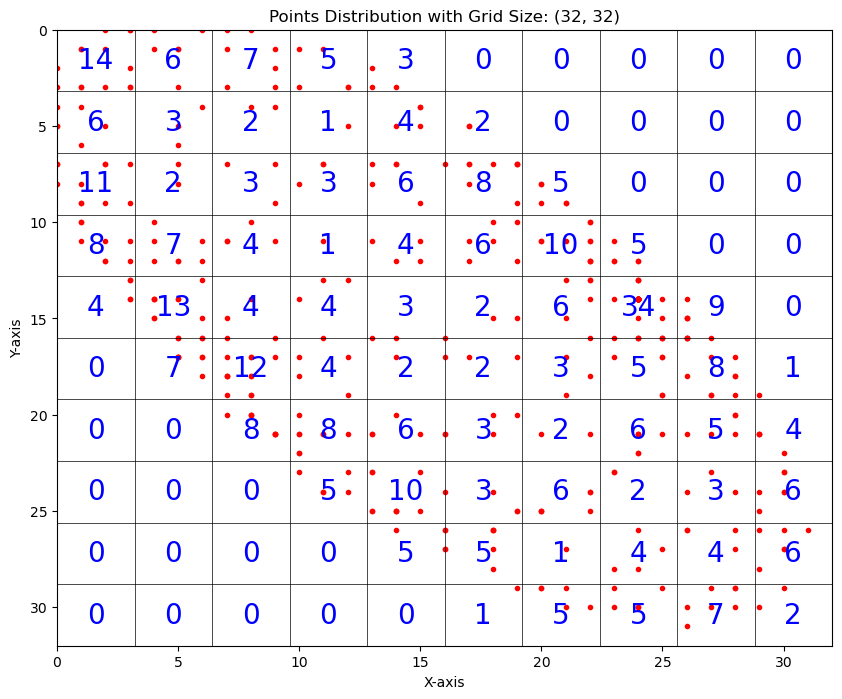

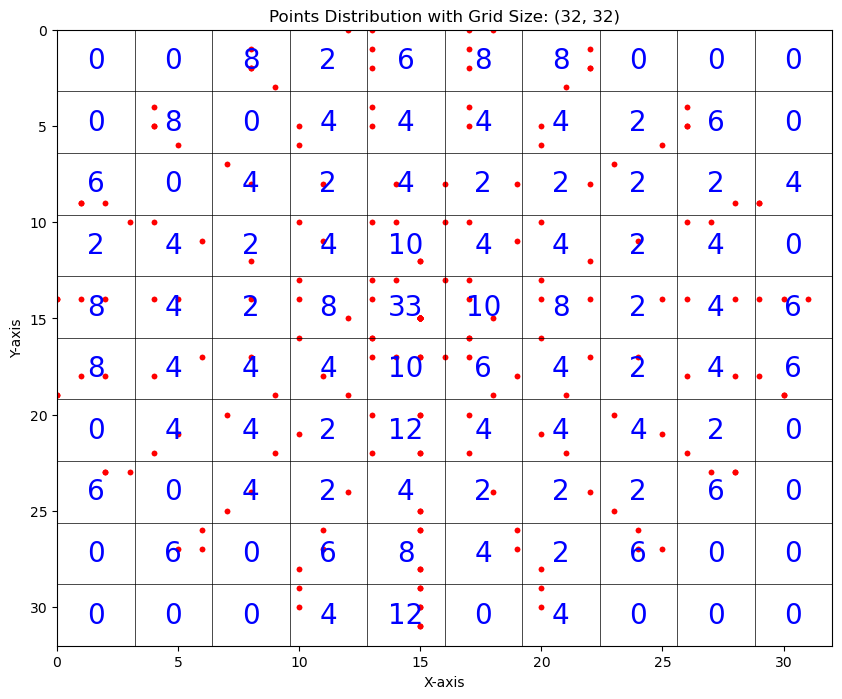

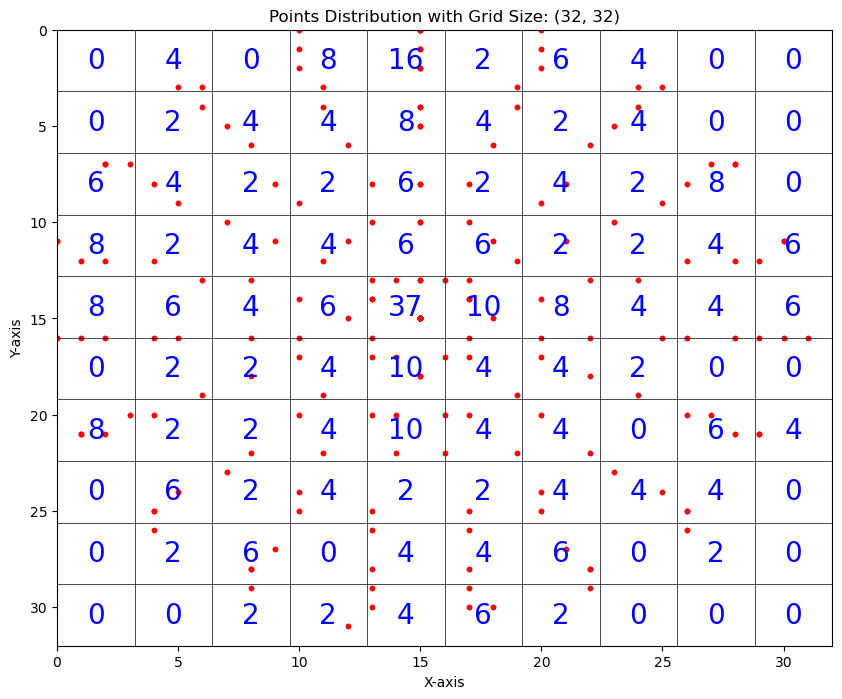

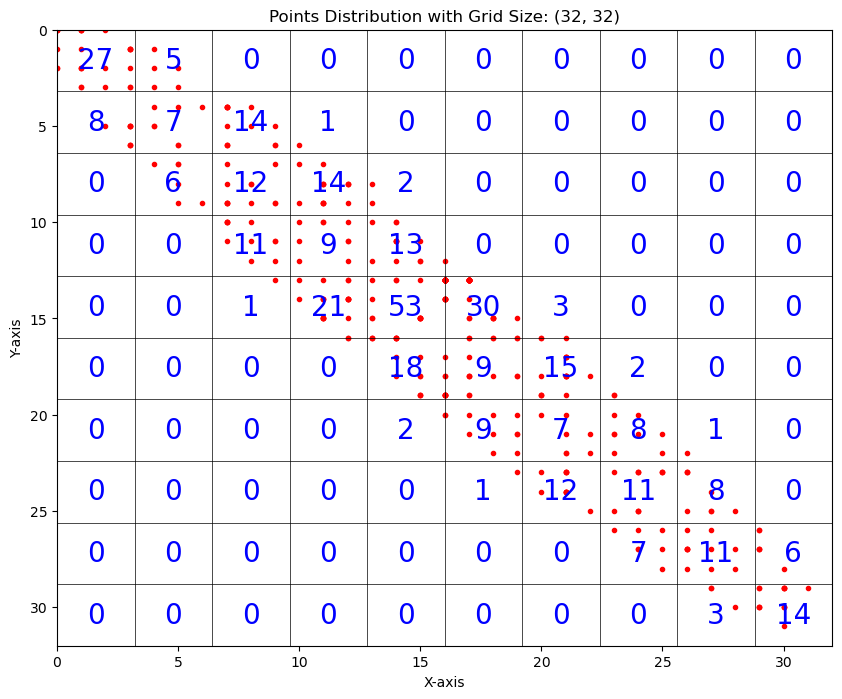

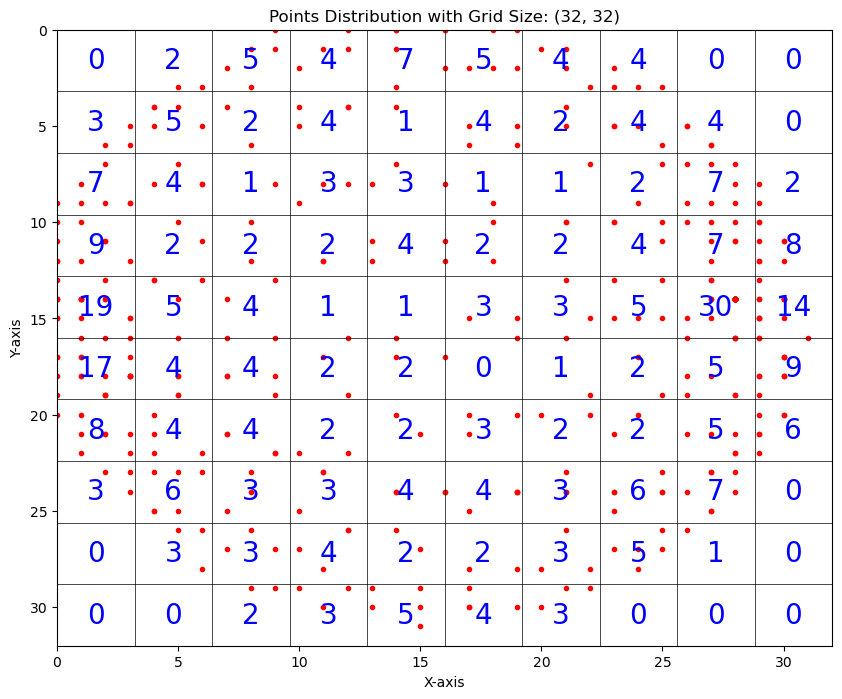

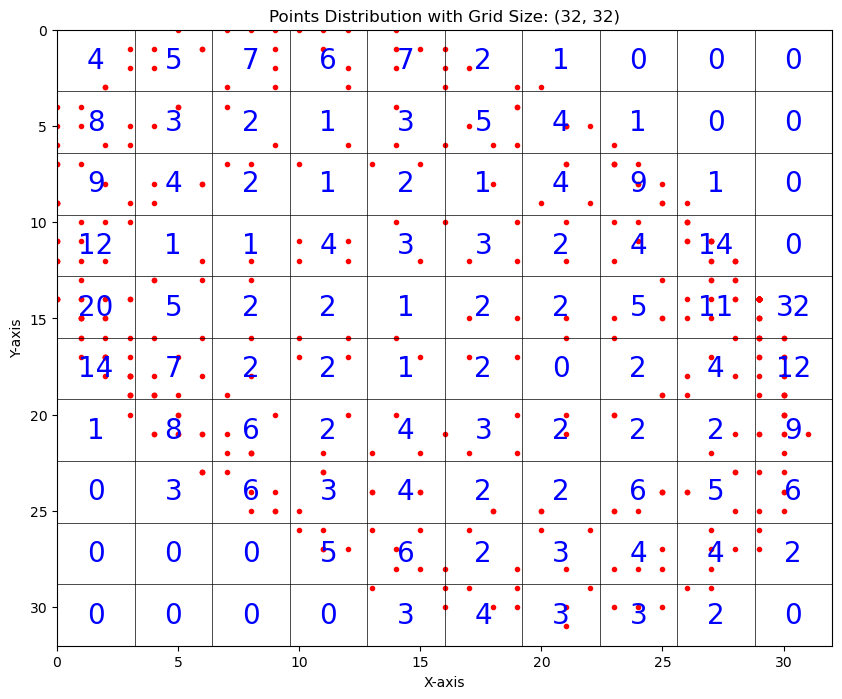

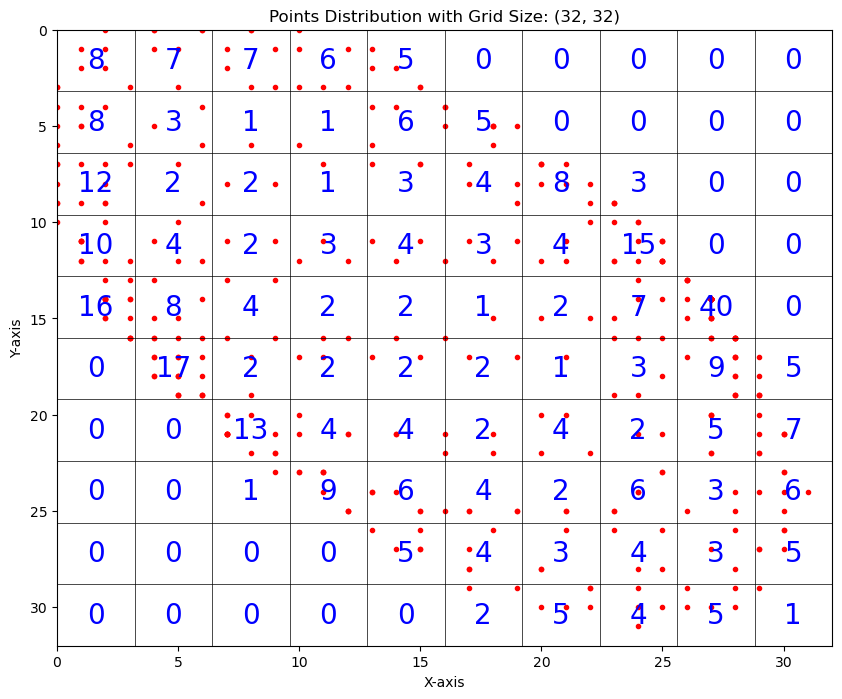

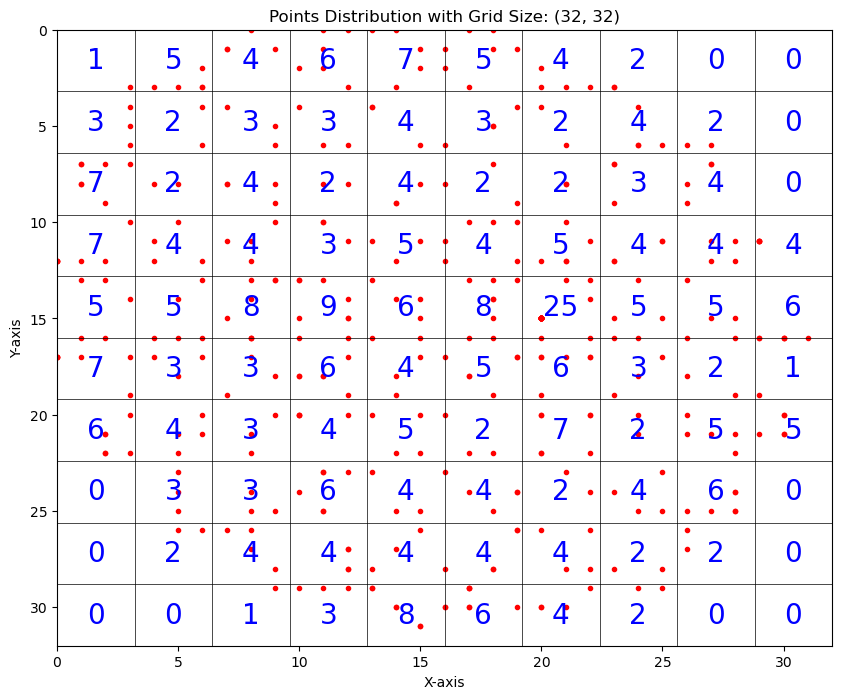

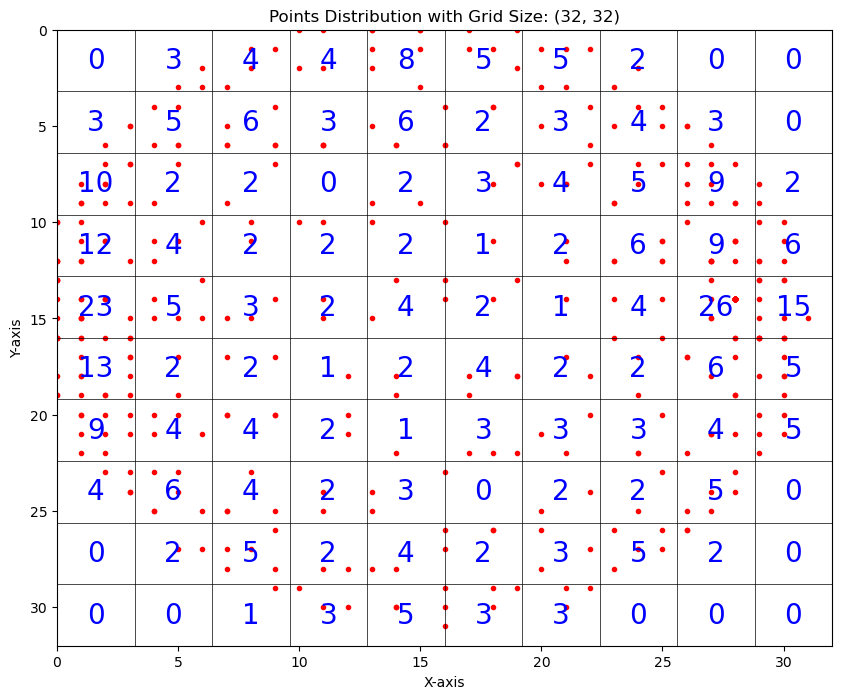

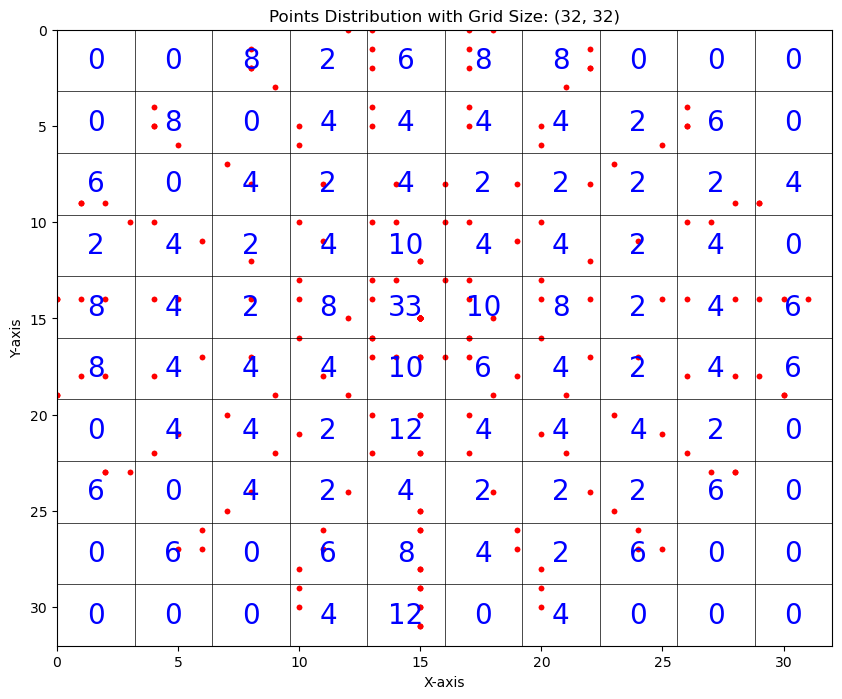

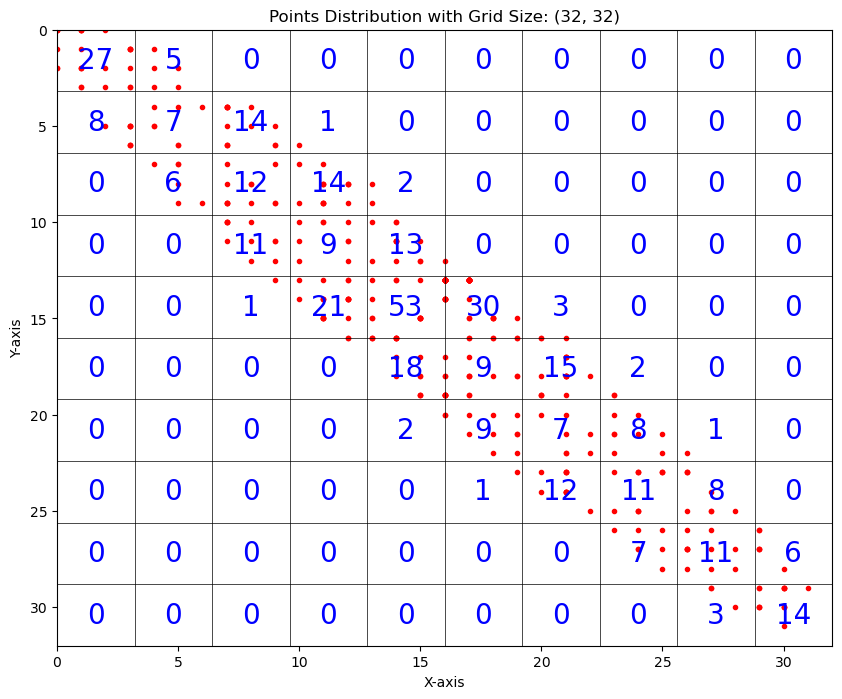

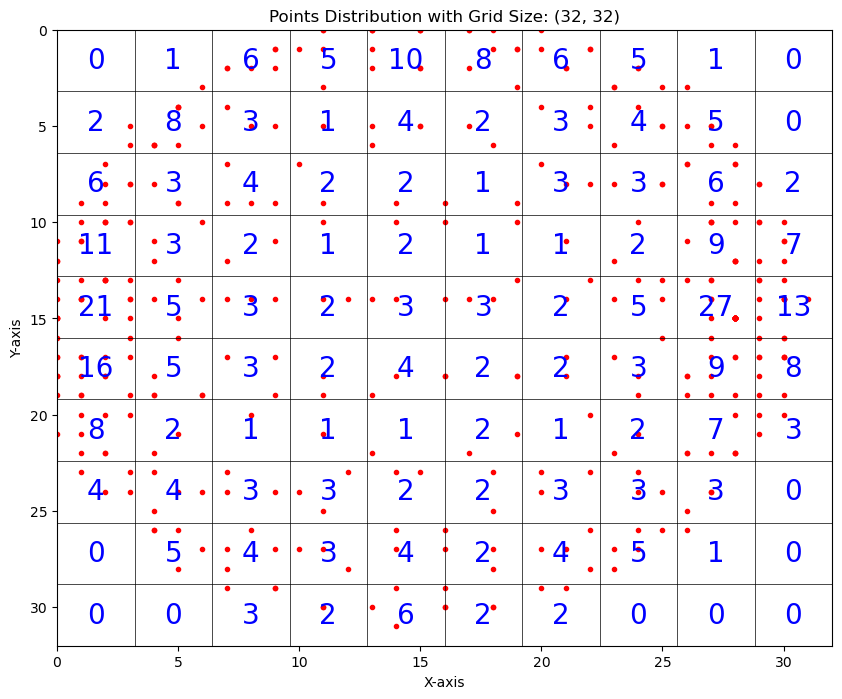

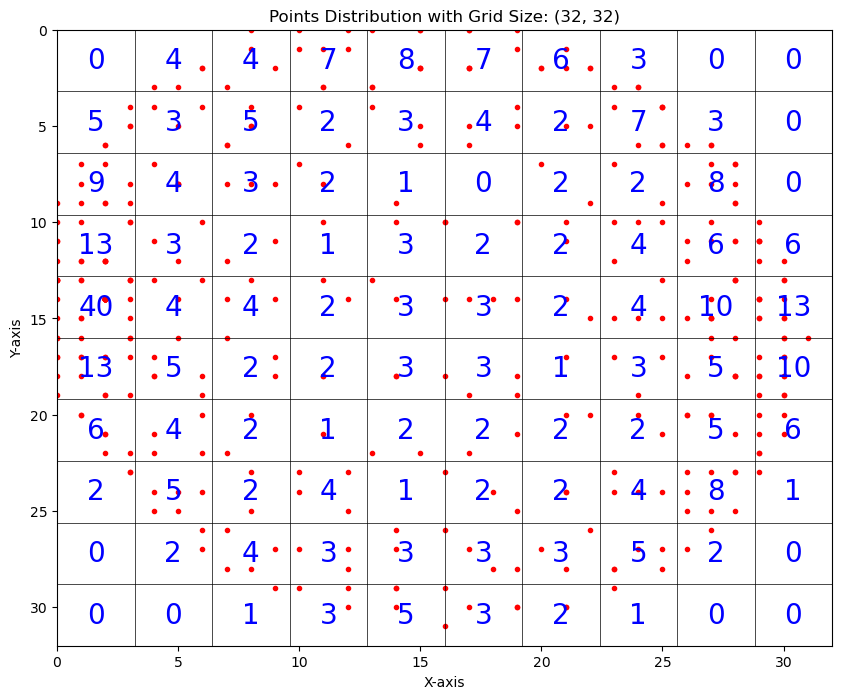

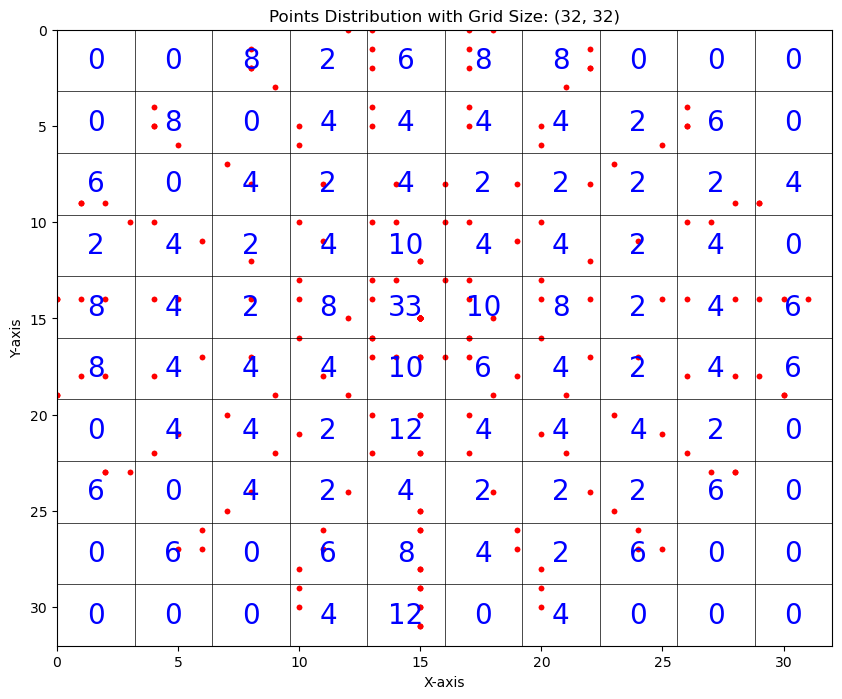

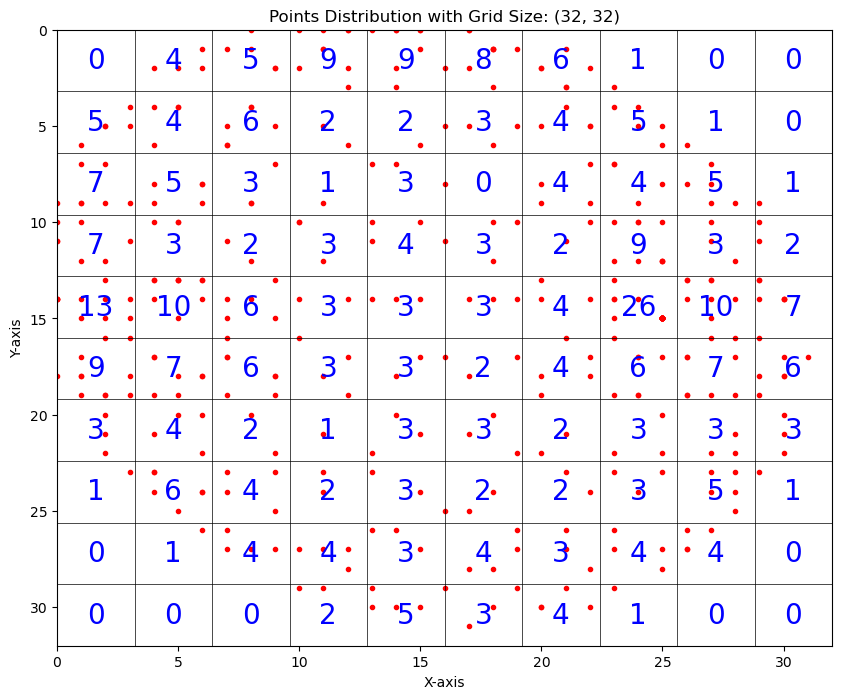

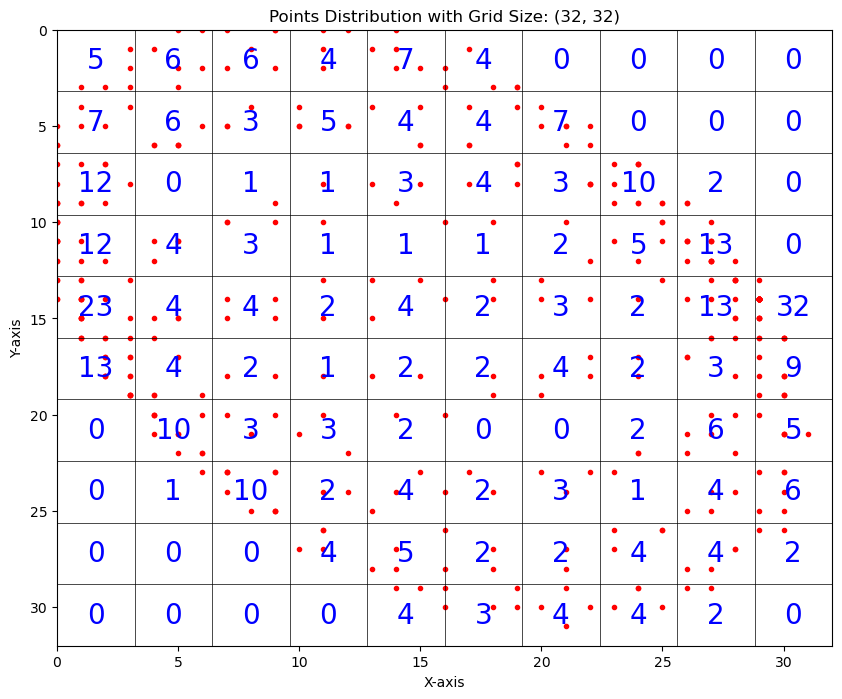

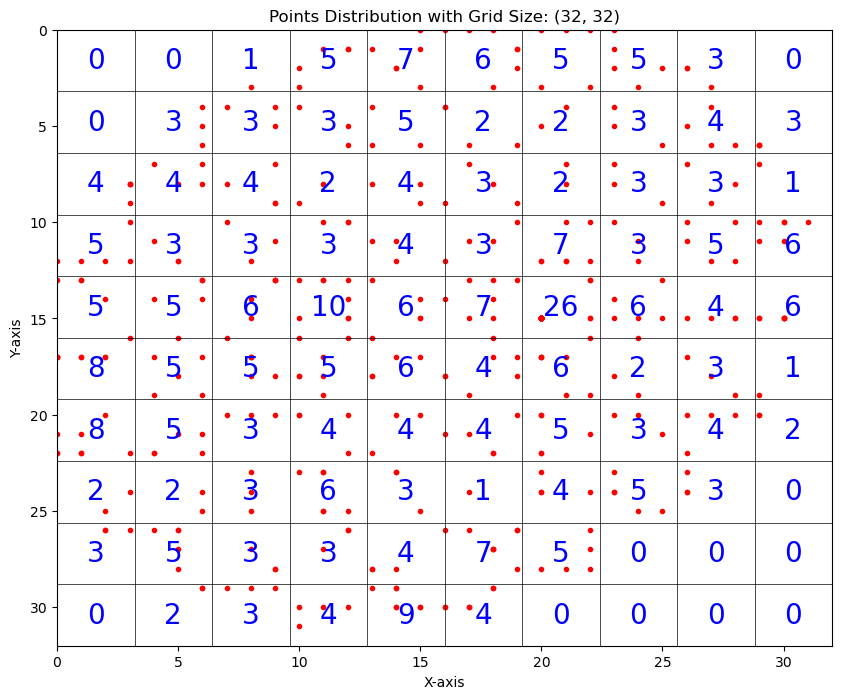

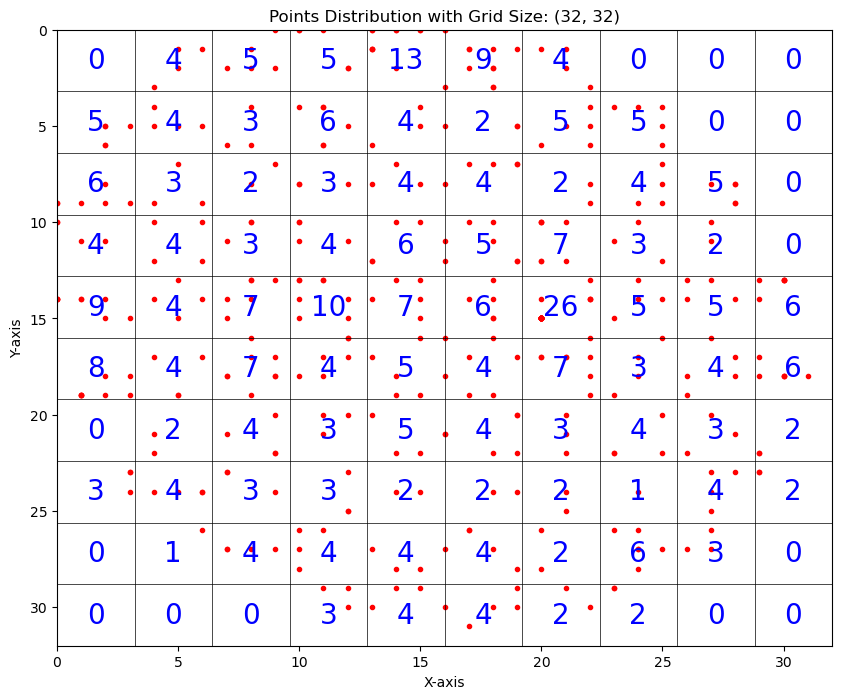

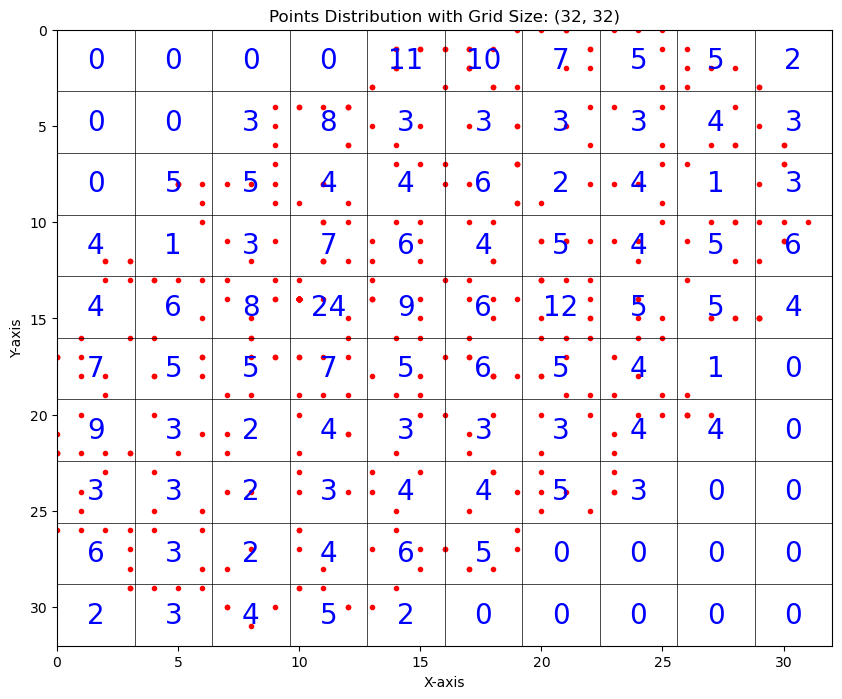

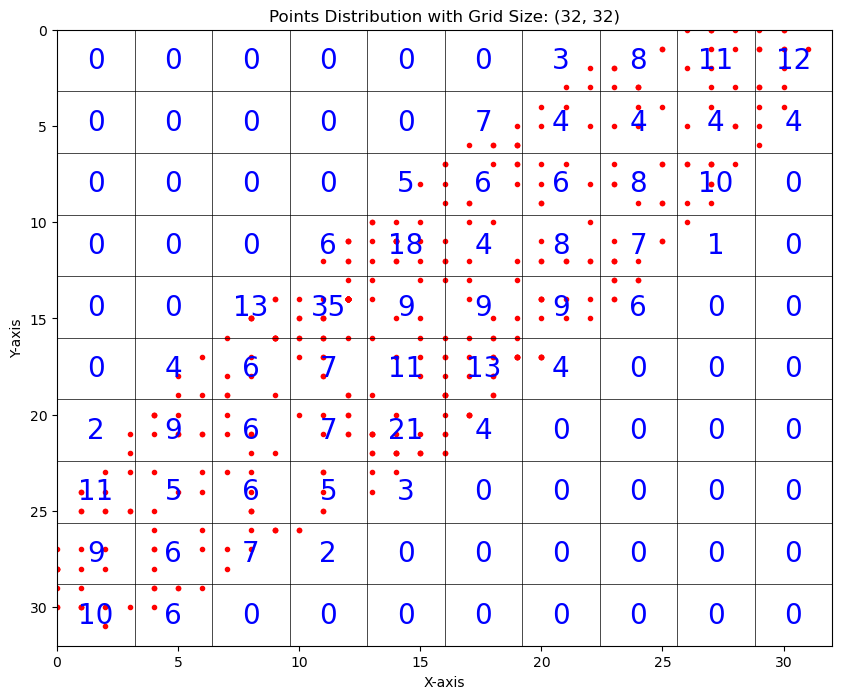

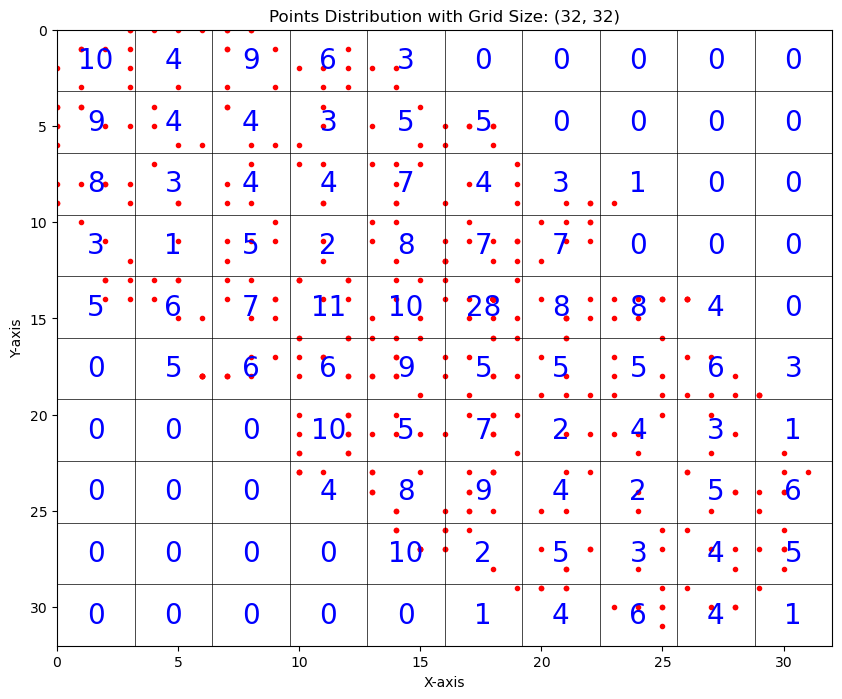

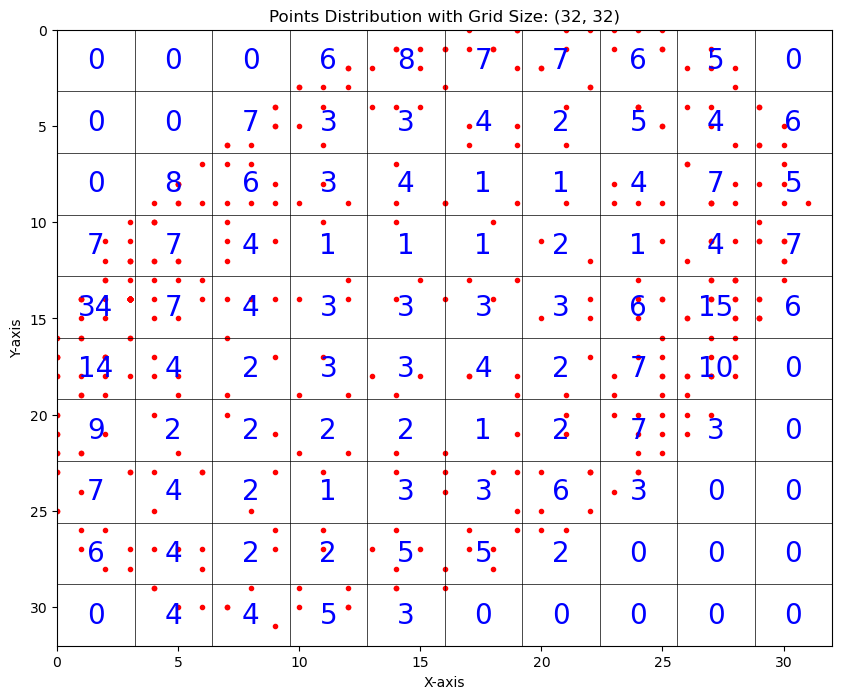

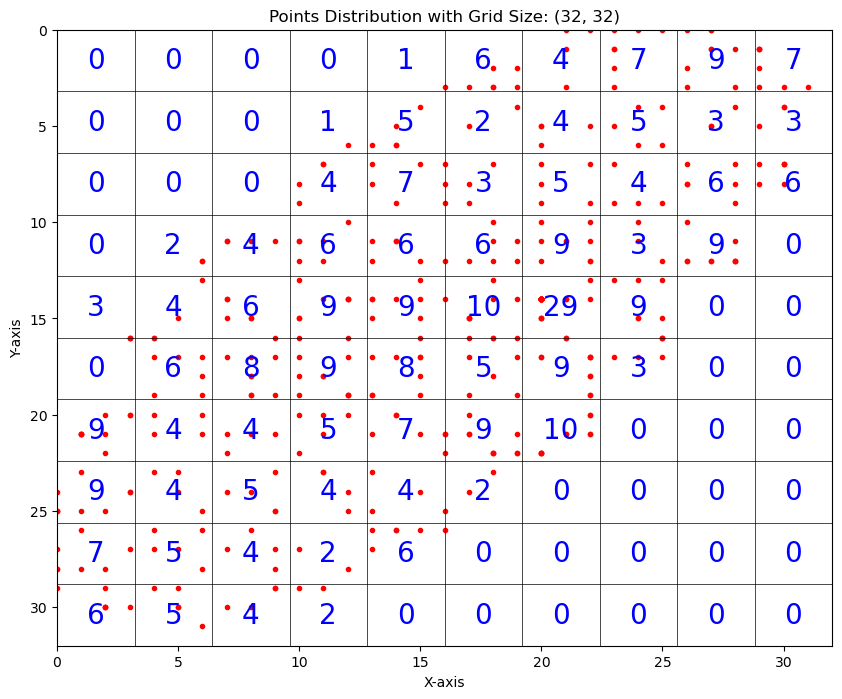

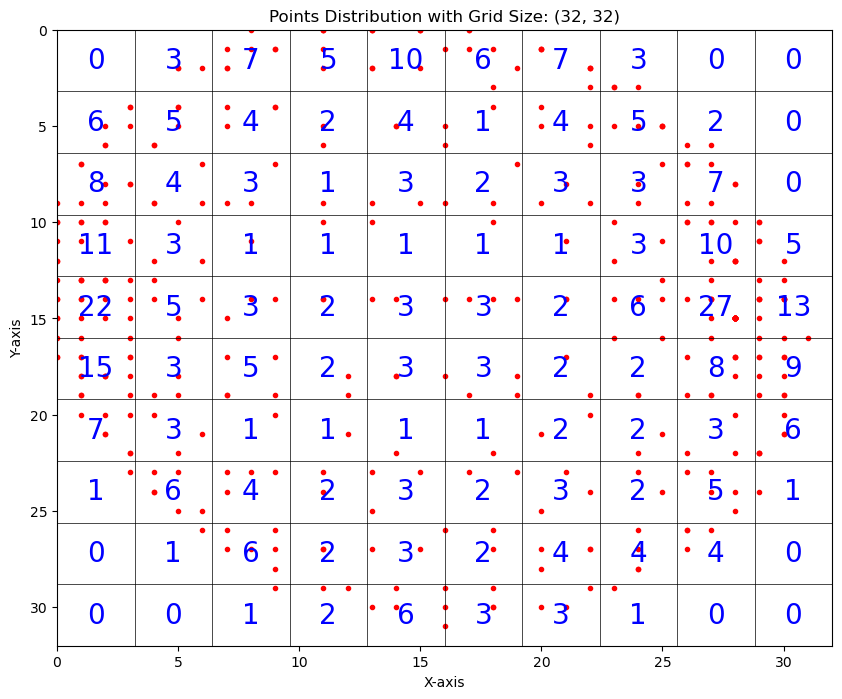

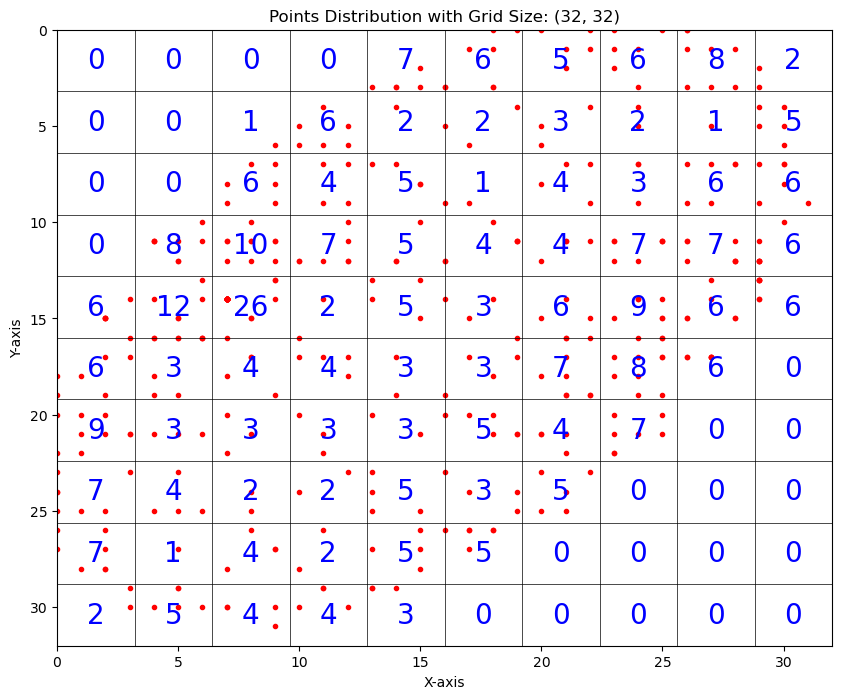

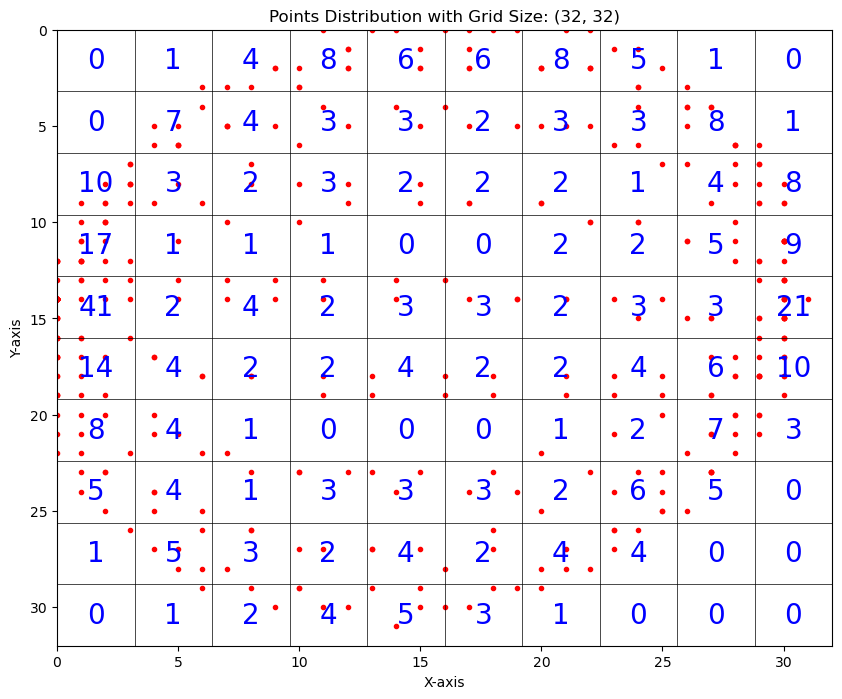

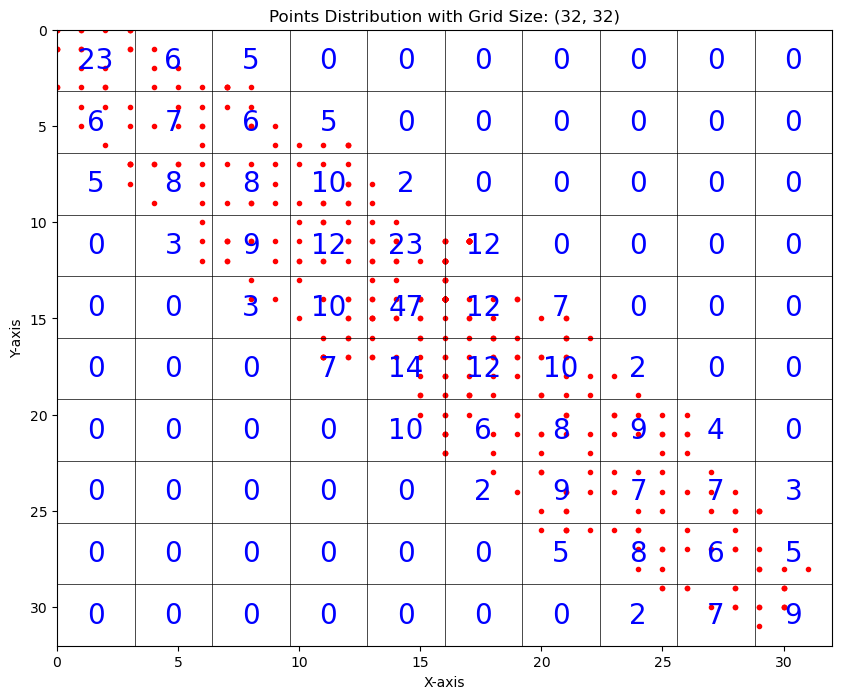

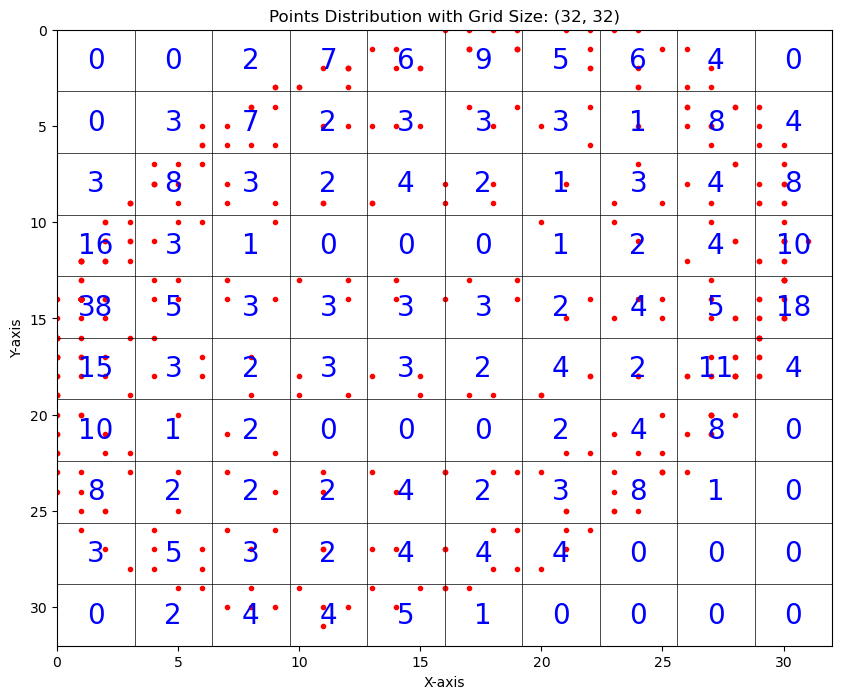

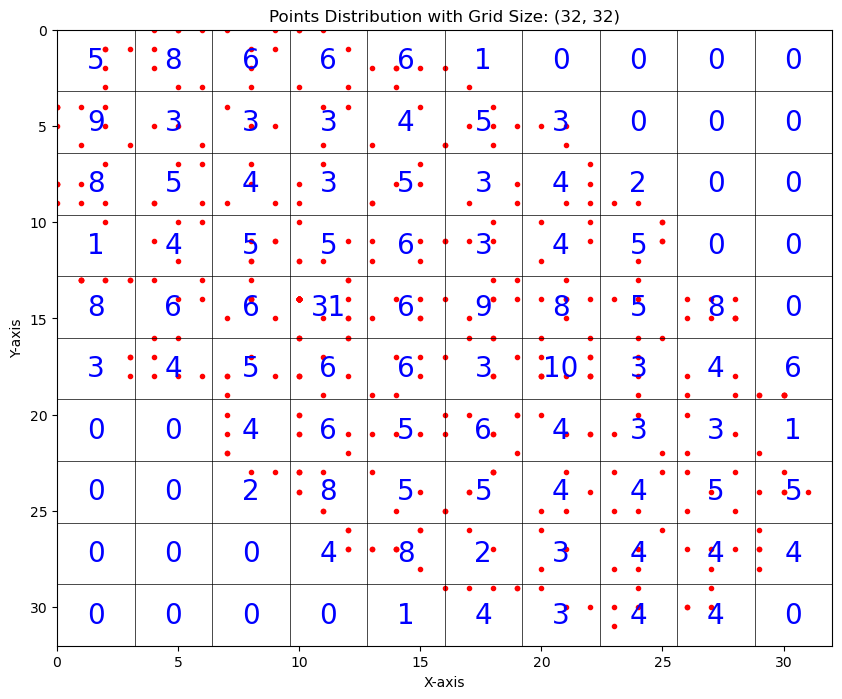

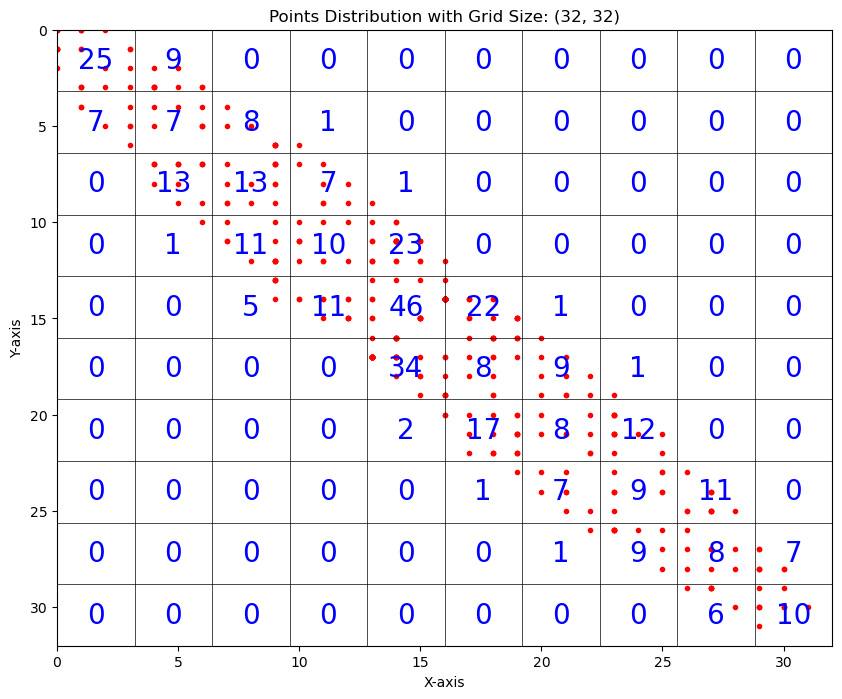

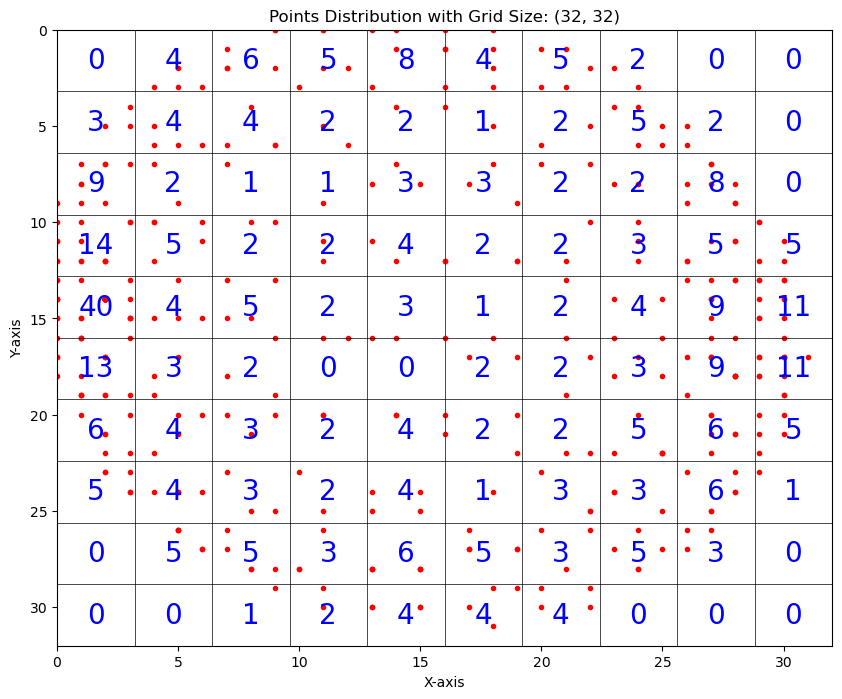

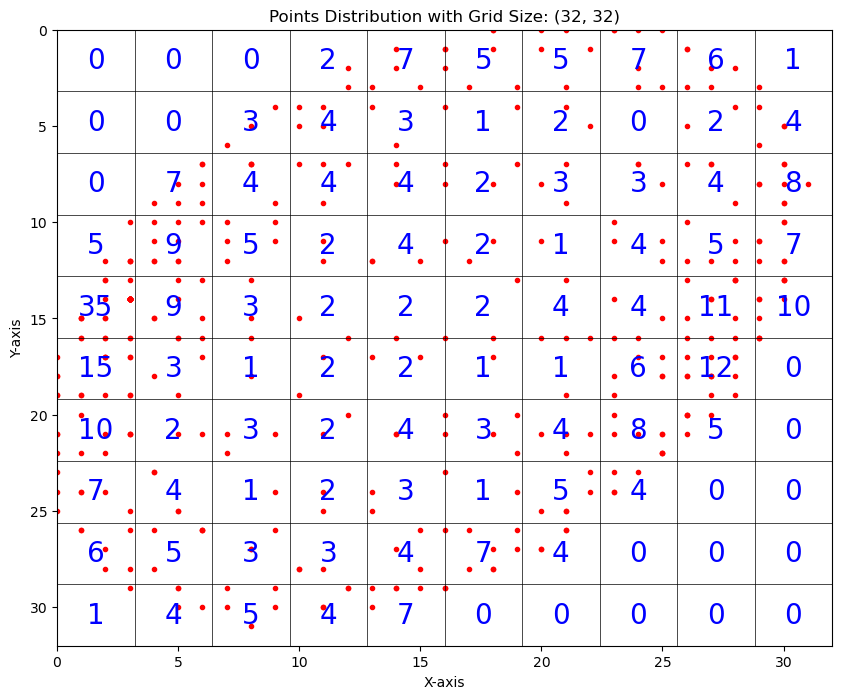

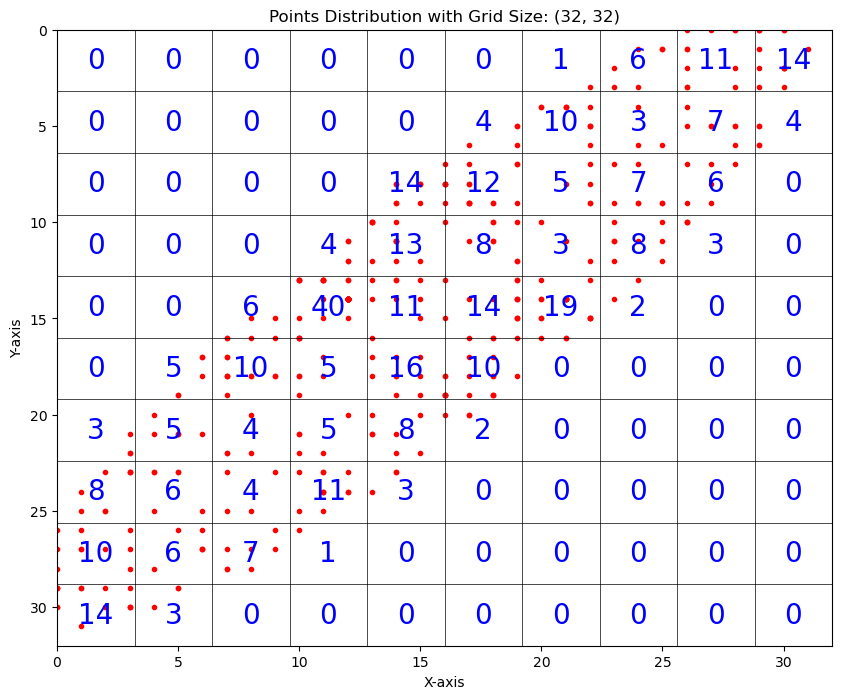

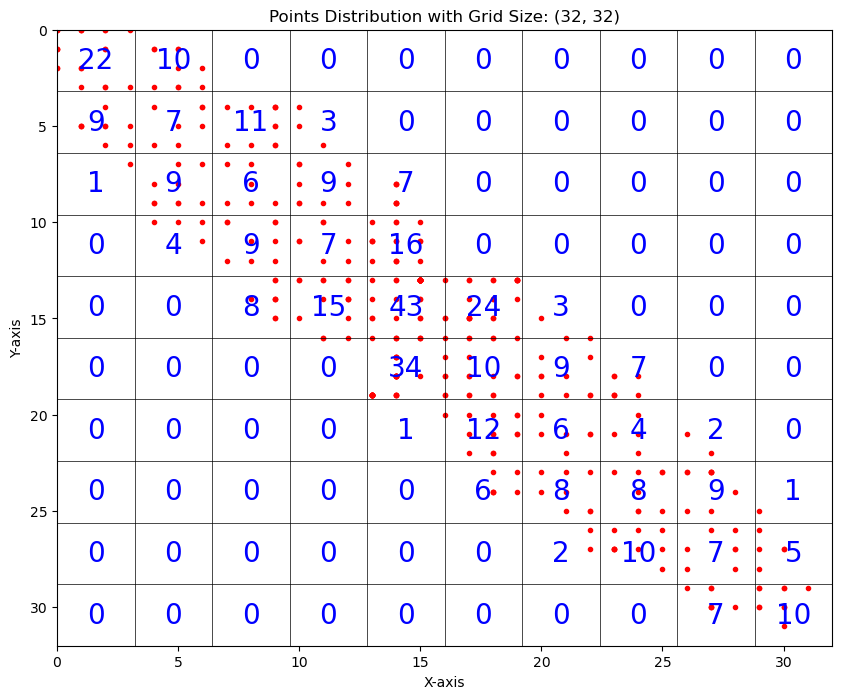

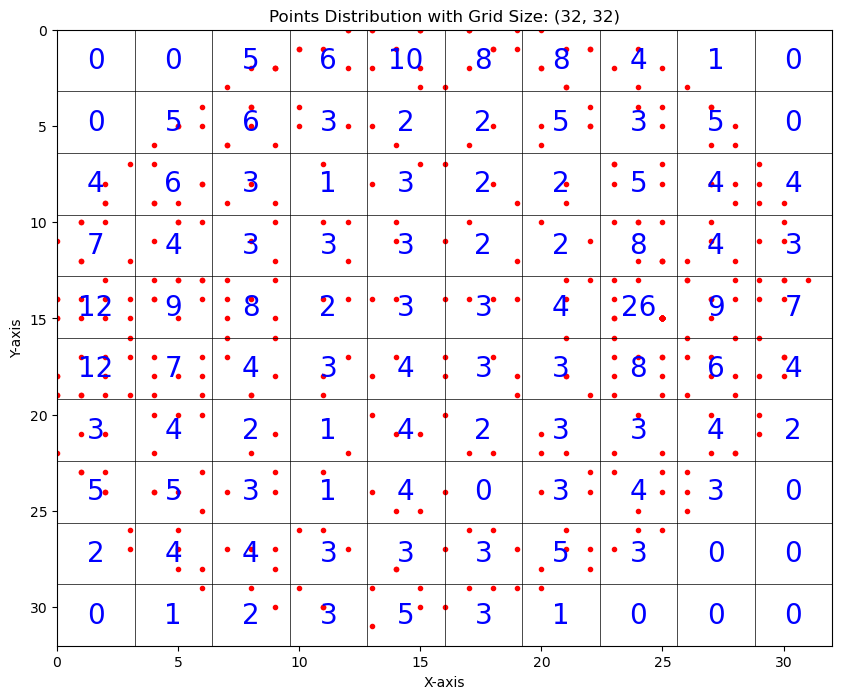

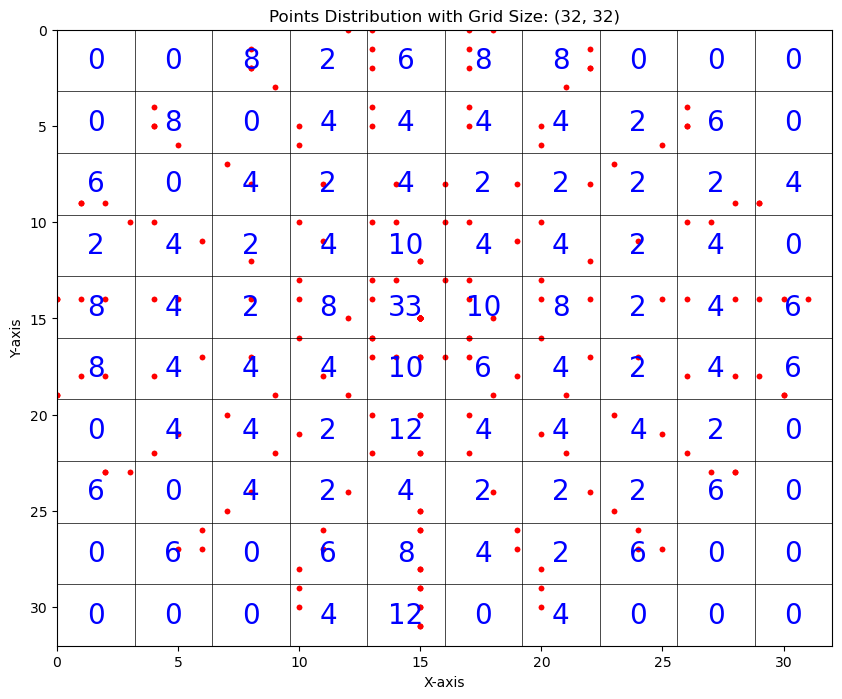

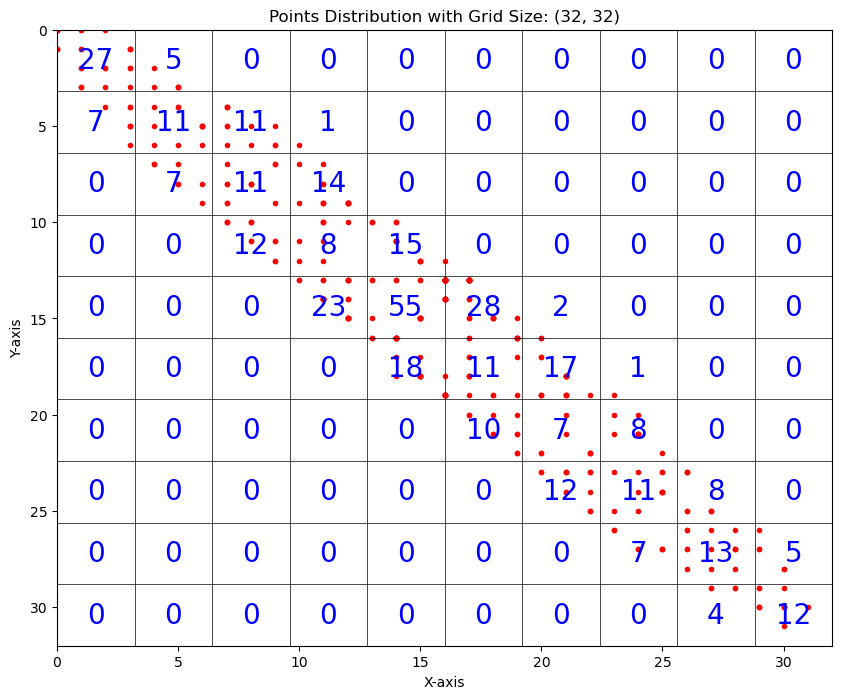

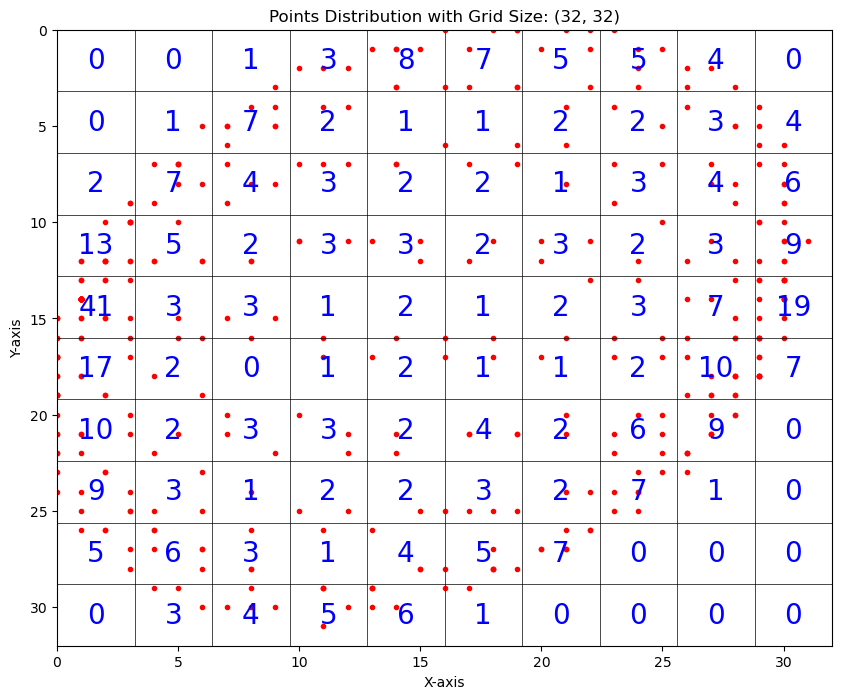

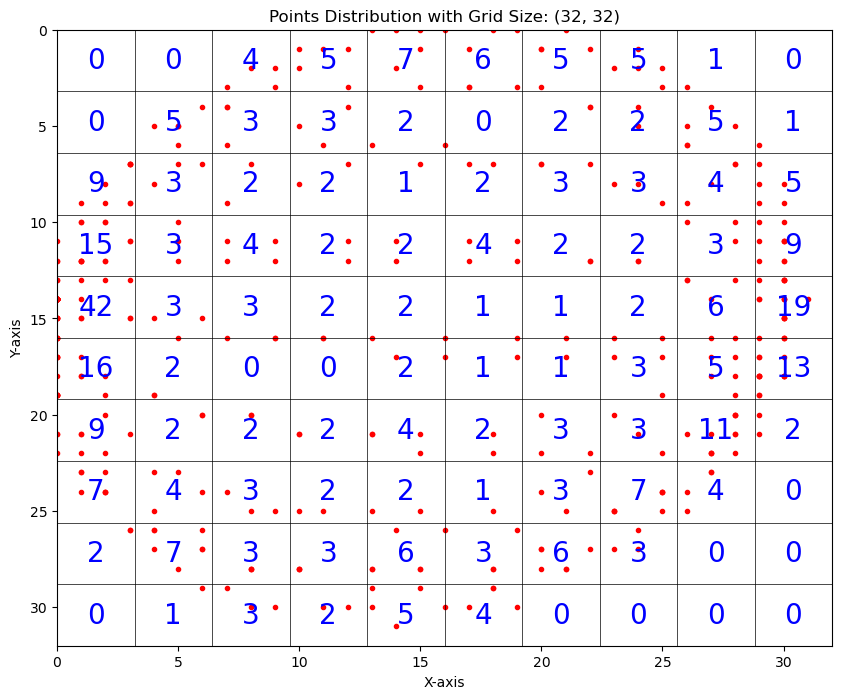

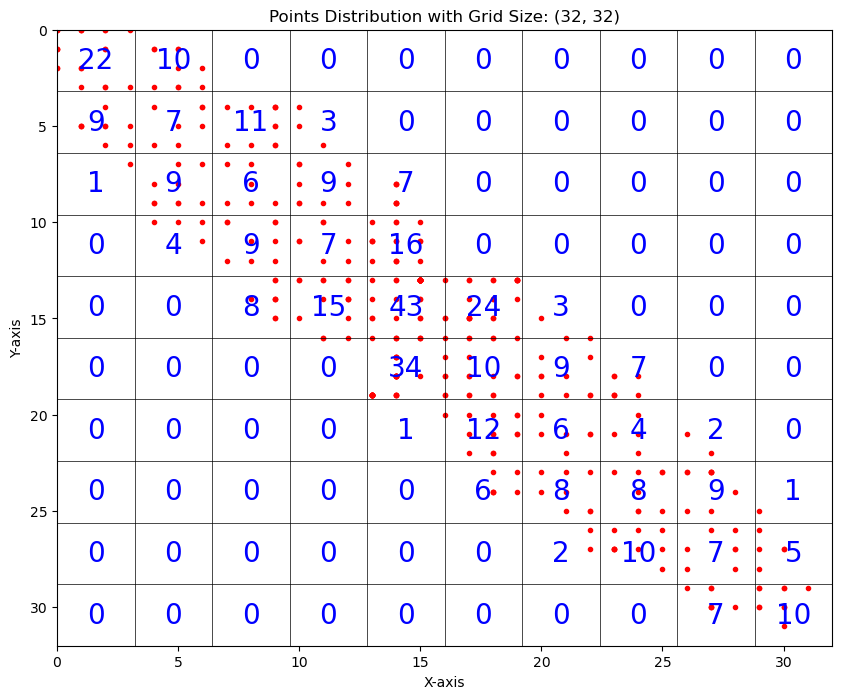

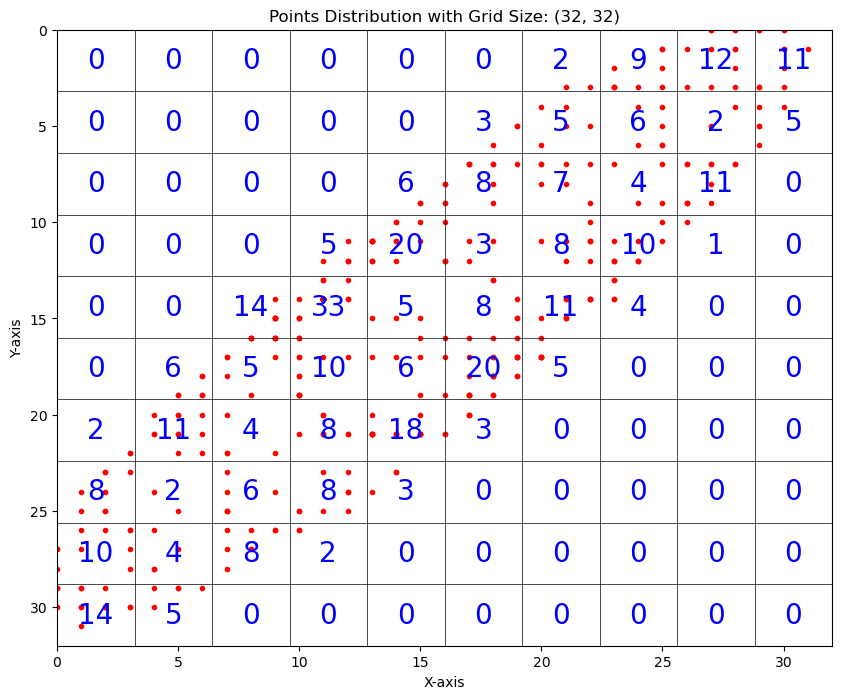

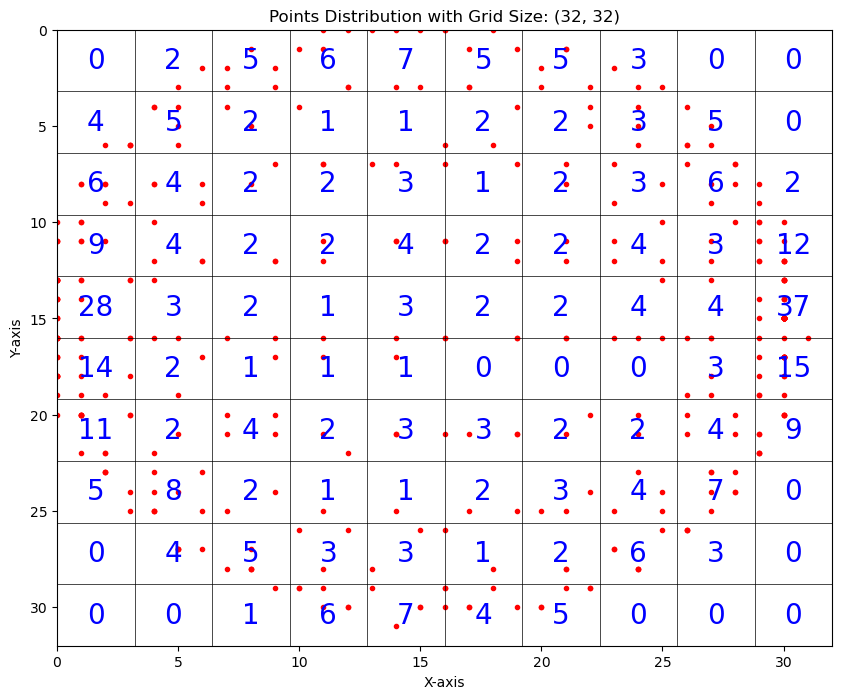

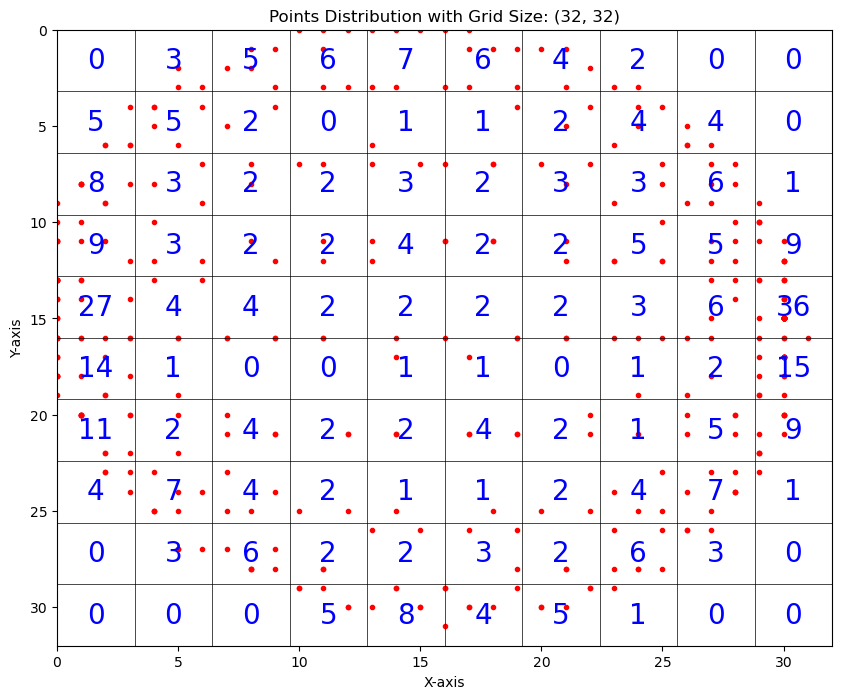

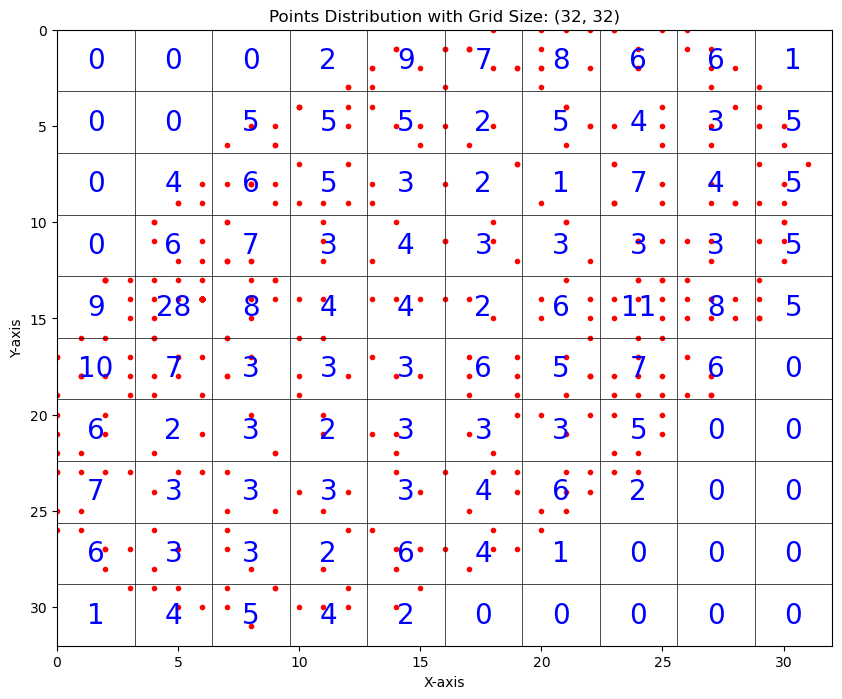

In [84]:
b = cluster_per_cell(projections,(32,32), (10,10))